# Credit Defaults Unveiled

## A Deep Dive into Predictive Insights – A Banking Case Study

Overview: This project delves into the realm of credit default prediction within the banking sector. By leveraging advanced machine learning techniques, we aim to build a model that identifies customers likely to default on credit obligations. This predictive tool has the potential to enhance risk assessment practices, optimize resource allocation, and fortify the stability of financial institutions. Through data-driven methodologies and insightful analysis, this project aspires to contribute to the evolution of credit risk management in banking.

Objective: Construct a predictive model utilizing general borrower profiles and historical records to ascertain the probability of significant delinquency occurring within the subsequent two years.

Business Context: Banks primarily engage in the business of lending money. Maximizing revenue involves lending to individuals who demonstrate a capacity for timely repayment, thereby generating substantial interest. By effectively identifying borrowers heading toward serious delinquency, banks can significantly bolster their money lending operations. This not only enhances revenue but also cultivates a favorable market image and a competitive edge.

Delinquency and Default: Delinquency is a milder term indicating borrowers who are lagging behind in repayment by a few months, while "default" refers to borrowers significantly behind in payments for an extended period and unlikely to make amends.

Key Data Points: Our dataset includes borrower profiles such as age, monthly income, and dependents, along with historical information like debt ratio, owed amount relative to the credit limit, and past default instances within different timeframes. Leveraging these features, we aim to predict whether a borrower is likely to become delinquent within the next two years.

Now, let us dive into the project by integrating our data source as google drive and hence loading it.

In [1]:
!ls /datasets/datalab/ds-ml/credit-default-predict

cs-test.csv  cs-training.csv


In [2]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

### Importing Required Libraries & ML Algorithms

In [3]:
# Importing required libraries for data analysis, statistics, visualization, and model interpretation
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import special, stats
from scipy.stats import kurtosis, skew
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer

In [4]:
# Importing required machine learning algorithms and related modules
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix,
    f1_score, mean_squared_error, precision_recall_curve, precision_score,
    recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, KFold, RandomizedSearchCV,
    RepeatedStratifiedKFold, StratifiedKFold, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# Additional imports
from sklearn.model_selection import train_test_split

In [5]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models, layers

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

# Print Keras version
print("Keras version:", tf.keras.__version__)


2023-08-23 23:18:22.807690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 23:18:22.921264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-23 23:18:22.921299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-23 23:18:22.939631: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-23 23:18:25.754731: W tensorflow/stream_executor/platform/de

In [6]:
# Print a confirmation message
print("Imports completed successfully.")

Imports completed successfully.


In [7]:
# Configure pandas to display all columns and rows in a dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)

### Loading the Data

In [8]:
# Reading the training dataset
df = pd.read_csv('/datasets/datalab/ds-ml/credit-default-predict/cs-training.csv')

# Display the number of rows and columns in the DataFrame
print("Number of rows and columns:", df.shape)


Number of rows and columns: (150000, 12)


In [9]:
# Display general information about attribute datatypes and missing values (if any)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

Comment: There are two columns i.e. MonthlyIncome  & NumberOfDependents in the data set having missing values. We can confirm that by finding the percentage of missing values in each column. We will deal with me later on though.

In [10]:
# Calculate the percentage of missing data in each feature
missing_percentage = round(df.isnull().sum(axis=0) / len(df), 2) * 100
print("Percentage of missing data in each feature:")
print(missing_percentage)

Percentage of missing data in each feature:
Unnamed: 0                               0.0
SeriousDlqin2yrs                         0.0
RevolvingUtilizationOfUnsecuredLines     0.0
age                                      0.0
NumberOfTime30-59DaysPastDueNotWorse     0.0
DebtRatio                                0.0
MonthlyIncome                           20.0
NumberOfOpenCreditLinesAndLoans          0.0
NumberOfTimes90DaysLate                  0.0
NumberRealEstateLoansOrLines             0.0
NumberOfTime60-89DaysPastDueNotWorse     0.0
NumberOfDependents                       3.0
dtype: float64


Let's go through the data at an initial level.

In [11]:
# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0           1                 1                              0.766127   45   
1           2                 0                              0.957151   40   
2           3                 0                              0.658180   38   
3           4                 0                              0.233810   30   
4           5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                   

Comment: The column named Unnamed: 0 may have unique values. In that case, we can rename that column as CustomerID.

In [12]:
# Calculate the percentage of unique borrowers based on the 'Unnamed: 0' column
unique_borrowers_percentage = df['Unnamed: 0'].nunique() / len(df)
unique_borrowers_percentage

1.0

In [13]:
# Rename the 'Unnamed: 0' column to 'CustomerID'
df.rename(columns={'Unnamed: 0': 'CustomerID'}, inplace=True)

# Display unique values in the 'SeriousDlqin2yrs' column (target variable)
print("Unique values in 'SeriousDlqin2yrs' column:", df['SeriousDlqin2yrs'].unique())

Unique values in 'SeriousDlqin2yrs' column: [1 0]


The column SeriousDlqin2yrs consists of two unique values only mapping Yes and No respectively.

In [14]:
# Calculate the percentage of borrowers falling in serious delinquency
serious_delinquency_percentage = (df['SeriousDlqin2yrs'].sum() / len(df)) * 100
print("{:.2f}% of borrowers are in serious delinquency.".format(serious_delinquency_percentage))

6.68% of borrowers are in serious delinquency.


Let's begin by conducting an initial scan of the dataset to gain a preliminary understanding of its contents.

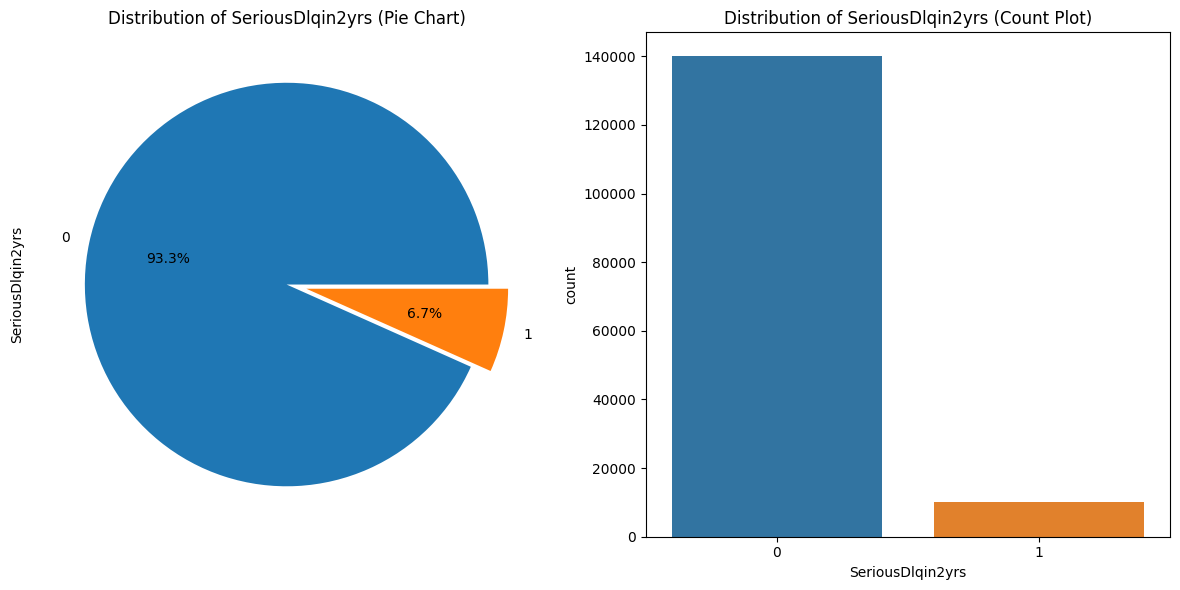

In [15]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot a pie chart for 'SeriousDlqin2yrs' distribution
df['SeriousDlqin2yrs'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=axes[0]
)
axes[0].set_title('Distribution of SeriousDlqin2yrs (Pie Chart)')

# Plot a count plot for 'SeriousDlqin2yrs'
sns.countplot(x='SeriousDlqin2yrs', data=df, ax=axes[1])
axes[1].set_title('Distribution of SeriousDlqin2yrs (Count Plot)')

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
# Display summary statistics of numerical columns
numerical_summary = df.describe()
print("\nSummary statistics of numerical columns:")
print(numerical_summary)


Summary statistics of numerical columns:
          CustomerID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  \
count  150000.000000     150000.000000                         150000.000000   
mean    75000.500000          0.066840                              6.048438   
std     43301.414527          0.249746                            249.755371   
min         1.000000          0.000000                              0.000000   
25%     37500.750000          0.000000                              0.029867   
50%     75000.500000          0.000000                              0.154181   
75%    112500.250000          0.000000                              0.559046   
max    150000.000000          1.000000                          50708.000000   

                 age  NumberOfTime30-59DaysPastDueNotWorse      DebtRatio  \
count  150000.000000                         150000.000000  150000.000000   
mean       52.295207                              0.421033     353.005076   
std   

### Splitting the Dataset

We will split the dataset into training(80%) on which modeling will be done using statistical/machine learning techniques. Another one is the test dataset(20%) on which predictions will be made and check how the model is performing.

In [17]:
# Separate the dataset into features (X) and target (y)
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

In [18]:
from sklearn.model_selection import train_test_split

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Display the shapes of the datasets
print("Shape of training dataset:", X_train.shape)
print("Shape of test dataset:", X_test.shape)

Shape of training dataset: (120000, 11)
Shape of test dataset: (30000, 11)


In [19]:
# Calculate and print event rates
print('Event rate in the training dataset:', np.mean(y_train))
print('Event rate in the test dataset:', np.mean(y_test))
print('Event rate in the entire dataset:', np.mean(y))

Event rate in the training dataset: 0.06684166666666666
Event rate in the test dataset: 0.06683333333333333
Event rate in the entire dataset: 0.06684


Comment: The event rate is maintained in the training and test dataset after splitting in line with the entire dataset.


In [20]:
# Concatenate features and target variables for train and test datasets
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Print shapes of the datasets
print("Shape of train dataset:", train.shape)
print("Shape of test dataset:", test.shape)

Shape of train dataset: (120000, 12)
Shape of test dataset: (30000, 12)


### Data Visualization

In [21]:
def plot_hist_boxplot(column, data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram plot
    sns.distplot(data[column].dropna(), ax=axes[0])
    axes[0].set_title(f'Histogram of {column}')
    
    # Box plot
    sns.boxplot(y=data[column].dropna(), ax=axes[1])
    axes[1].set_title(f'Box Plot of {column}')
    
    # Calculate and display skewness and kurtosis
    column_data = data[column].dropna()
    skewness = skew(column_data)
    kurt = kurtosis(column_data)
    print("skewness:", skewness)
    print("kurtosis:", kurt)
    
    plt.tight_layout()
    plt.show()

In [22]:
def plot_count_boxplot(column, data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Count plot
    sns.countplot(x=column, data=data, ax=axes[0])
    axes[0].set_title(f'Count Plot of {column}')
    
    # Box plot
    sns.boxplot(y=data[column], ax=axes[1])
    axes[1].set_title(f'Box Plot of {column}')
    
    # Calculate and display skewness and kurtosis
    column_data = data[column].dropna()
    skewness = skew(column_data)
    kurt = kurtosis(column_data)
    print("skewness:", skewness)
    print("kurtosis:", kurt)
    
    plt.tight_layout()
    plt.show()

skewness: 100.53820302006339
kurtosis: 15559.574874151434


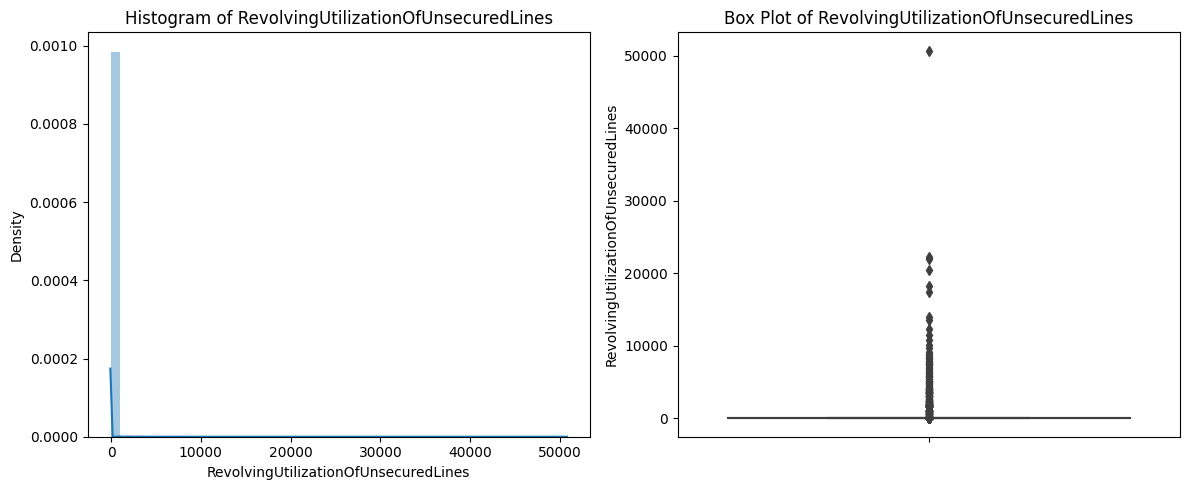

skewness: 99.14282373943726
kurtosis: 14370.263366125106


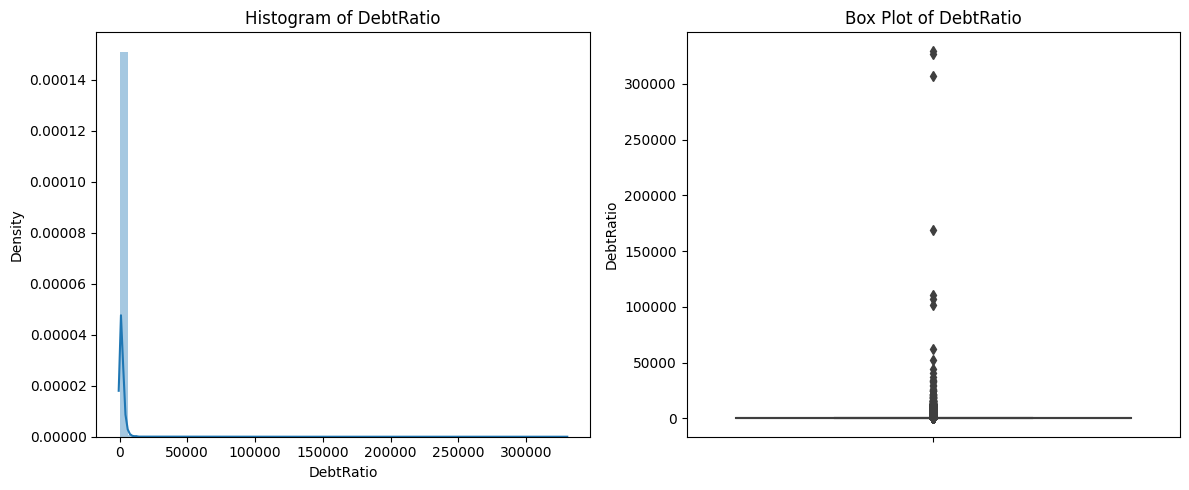

skewness: 122.58760175290827
kurtosis: 21861.235154793823


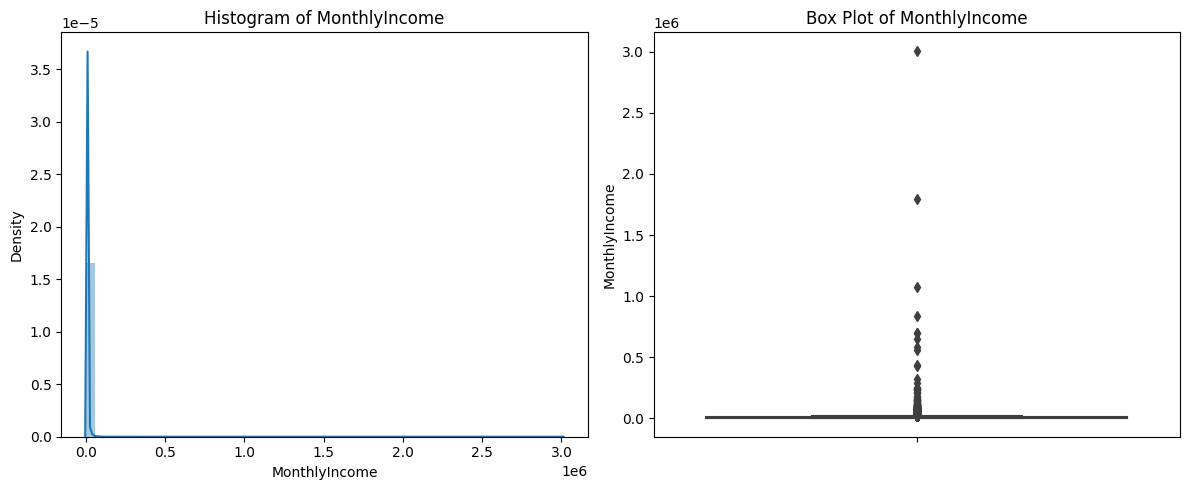

skewness: 1.228631935202937
kurtosis: 3.1788690218615834


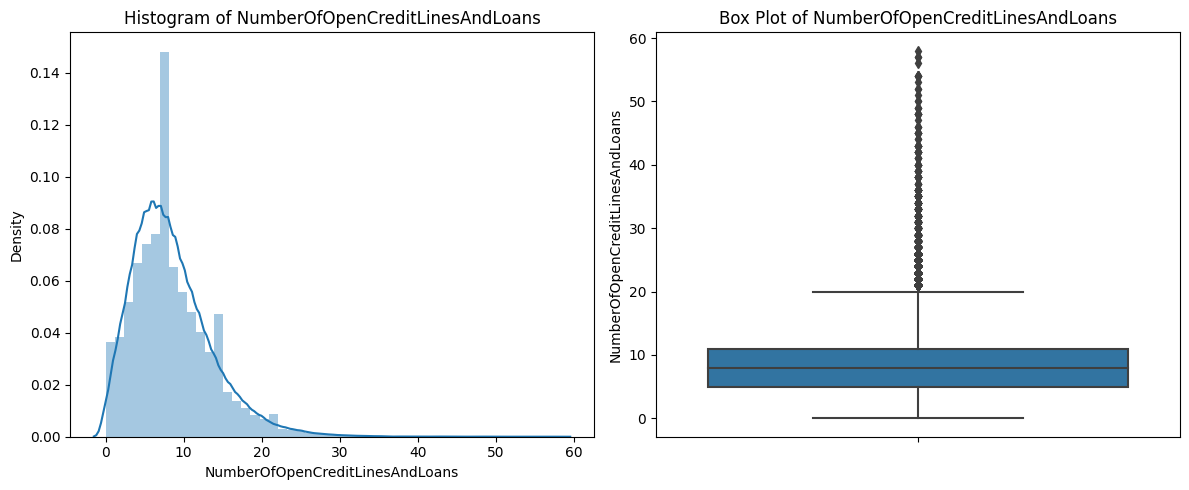

skewness: 3.752640736788862
kurtosis: 71.08765036833758


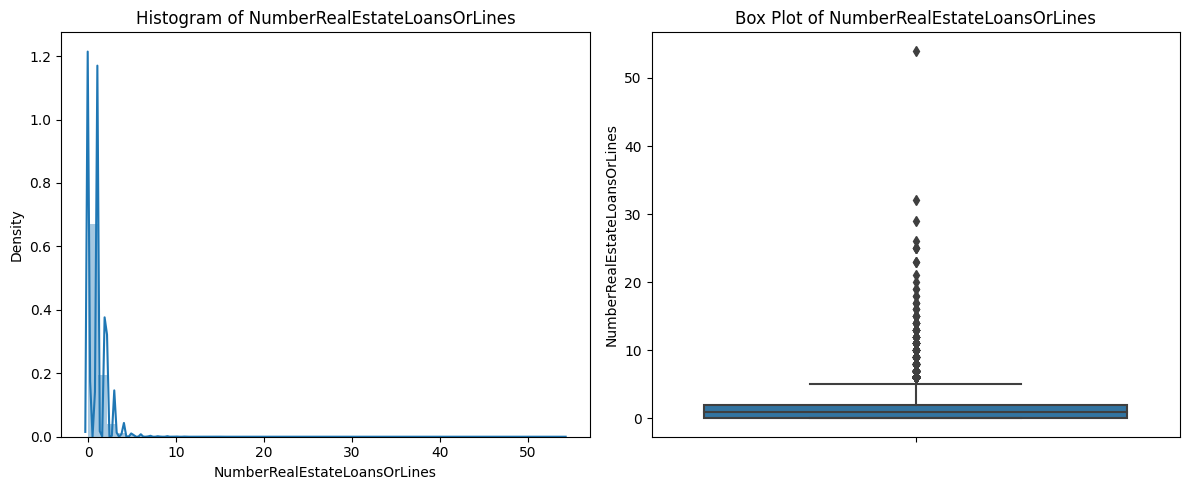

skewness: 22.656444686738023
kurtosis: 525.1798137690517


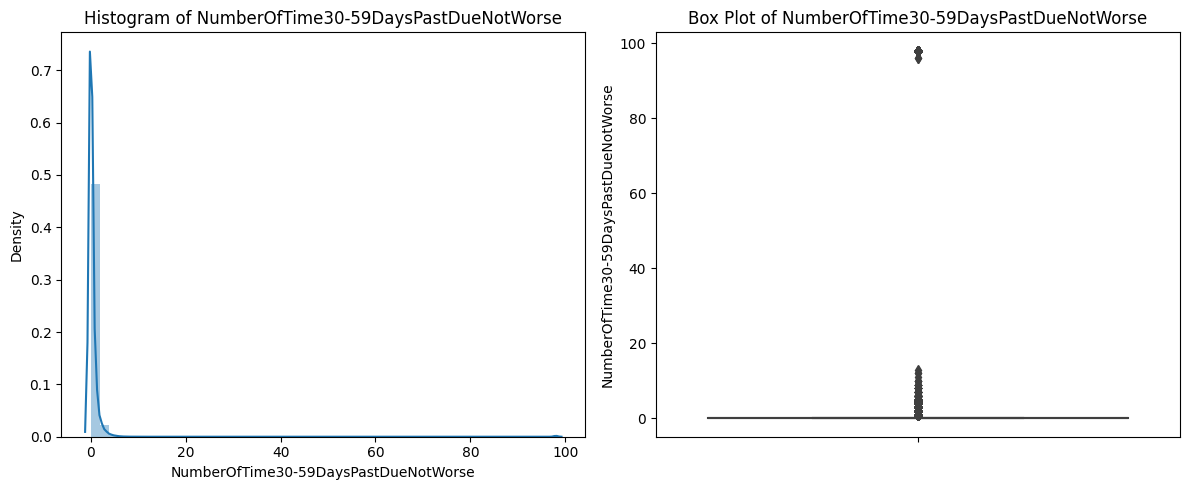

skewness: 23.393598377179494
kurtosis: 548.632426633495


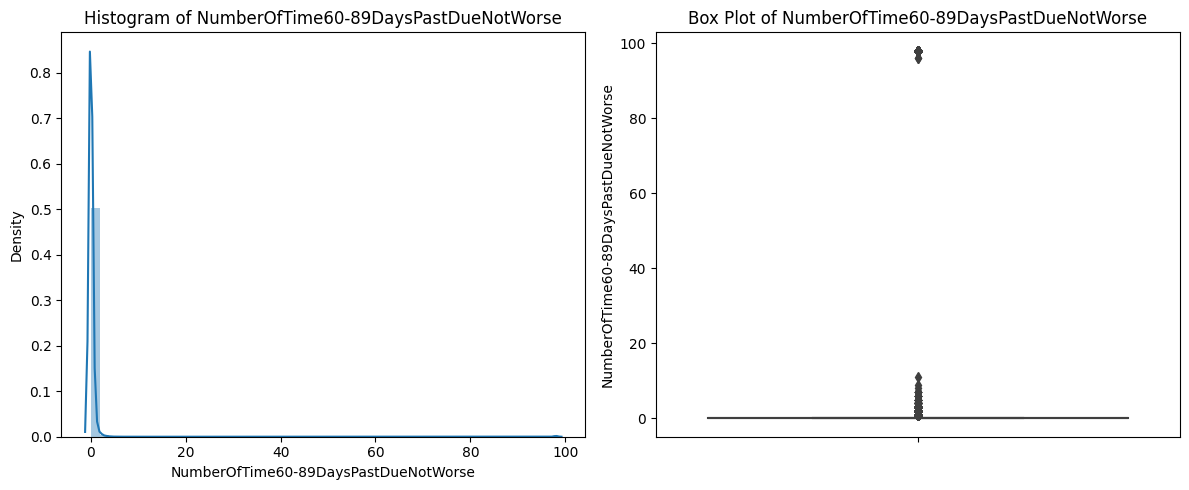

skewness: 23.155584699487473
kurtosis: 540.8745184818808


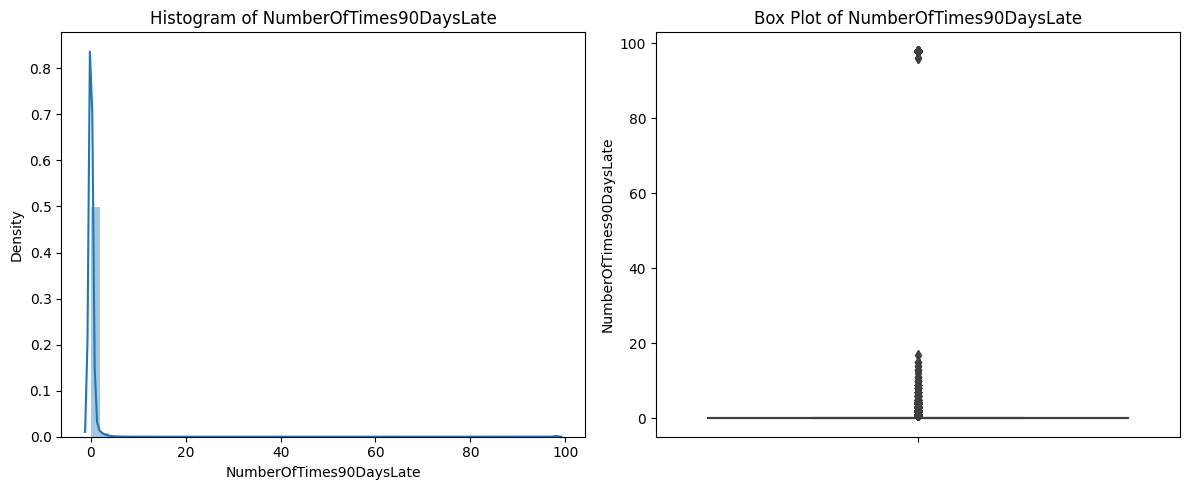

In [23]:
columns_to_plot = [
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]

for column in columns_to_plot:
    plot_hist_boxplot(column, train)


skewness: 1.5985560487376647
kurtosis: 3.1785476956522656


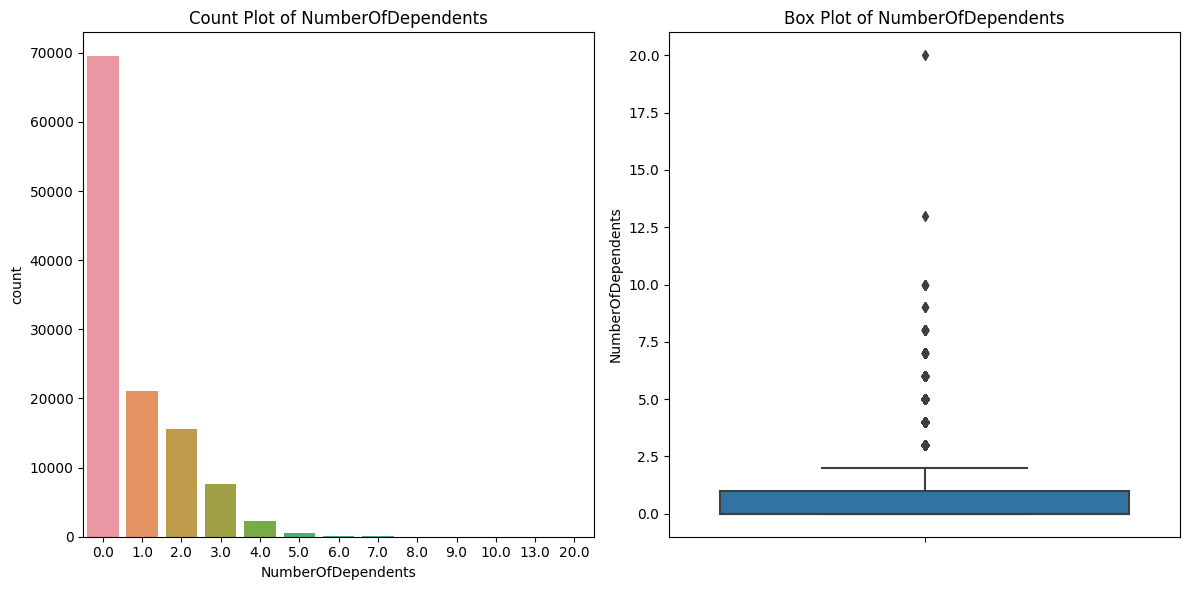

skewness: 0.18619637326841987
kurtosis: -0.498427938670404


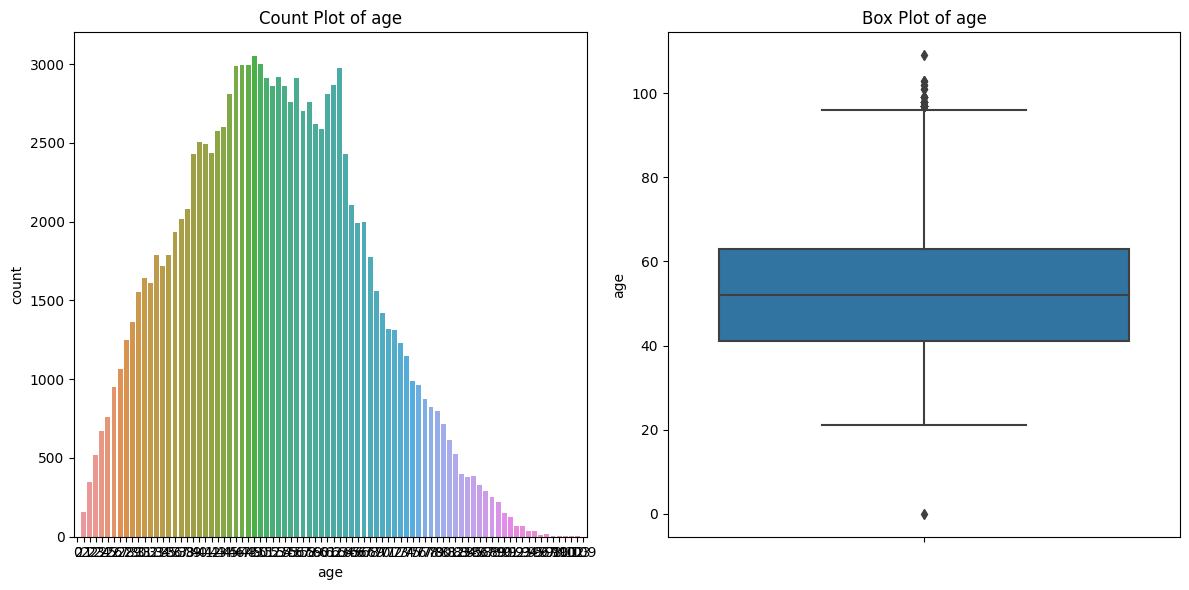

In [24]:
plot_count_boxplot('NumberOfDependents', train)
plot_count_boxplot('age', train)

In [25]:
cols_for_stats = ['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']

skewness = []
kurt = []

for column in cols_for_stats:
    column_data = train[train[column].notnull()][column]
    skewness.append(skew(column_data))
    kurt.append(kurtosis(column_data))

stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurt}, index=cols_for_stats)
sorted_stats = stats.sort_values(by='Skewness', ascending=False)

print(sorted_stats)

                                        Skewness      Kurtosis
MonthlyIncome                         122.587602  21861.235155
RevolvingUtilizationOfUnsecuredLines  100.538203  15559.574874
DebtRatio                              99.142824  14370.263366
NumberOfTime60-89DaysPastDueNotWorse   23.393598    548.632427
NumberOfTimes90DaysLate                23.155585    540.874518
NumberOfTime30-59DaysPastDueNotWorse   22.656445    525.179814
NumberRealEstateLoansOrLines            3.752641     71.087650
NumberOfDependents                      1.598556      3.178548
NumberOfOpenCreditLinesAndLoans         1.228632      3.178869
age                                     0.186196     -0.498428


Comment: We did a univariate analysis of the training data here. As per the observation, the data distribution in most columns is strongly right-skewed, with significantly high kurtosis values indicating the presence of extreme outliers within those columns. Notably, the age column exhibits a relatively more normal distribution compared to the other attributes.

### Treating the Outliers

From the above boxplot graphs, we can observe:
In the columns NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, and NumberOfTimes90DaysLate, we see delinquency range beyond 90 which is common across all 3 features.

Treating outliers for the columns: NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate

In [26]:
def print_unique_values(column, values):
    print(f"Unique values in '{column}' values:", values)

def calculate_proportion_positive_class(delinquency_data):
    positive_class_proportion = (delinquency_data['SeriousDlqin2yrs'].sum() / len(delinquency_data)) * 100
    return round(positive_class_proportion, 2)


In [27]:
# Select relevant columns
delinquency_30_59 = train[train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]
delinquency_30_59_less_90 = train[train['NumberOfTime30-59DaysPastDueNotWorse'] < 90]

# Unique values in columns when >= 90 days delinquency
unique_30_59_delinquent = np.unique(delinquency_30_59['NumberOfTime30-59DaysPastDueNotWorse'])
unique_60_89_delinquent = np.unique(delinquency_30_59['NumberOfTime60-89DaysPastDueNotWorse'])
unique_90_days_delinquent = np.unique(delinquency_30_59['NumberOfTimes90DaysLate'])

# Unique values in columns when < 90 days delinquency
unique_30_59_non_delinquent = np.unique(delinquency_30_59_less_90['NumberOfTime30-59DaysPastDueNotWorse'])
unique_60_89_non_delinquent = np.unique(delinquency_30_59_less_90['NumberOfTime60-89DaysPastDueNotWorse'])
unique_90_days_non_delinquent = np.unique(delinquency_30_59_less_90['NumberOfTimes90DaysLate'])

# Proportion of positive class with special 96/98 values
proportion_special_values = calculate_proportion_positive_class(delinquency_30_59)

# Printing
print_unique_values('30-59 Days (>= 90)', unique_30_59_delinquent)
print_unique_values('60-89 Days (>= 90)', unique_60_89_delinquent)
print_unique_values('90 Days (>= 90)', unique_90_days_delinquent)

print_unique_values('30-59 Days (< 90)', unique_30_59_non_delinquent)
print_unique_values('60-89 Days (< 90)', unique_60_89_non_delinquent)
print_unique_values('90 Days (< 90)', unique_90_days_non_delinquent)

print(f"Proportion of positive class with special 96/98 values: {proportion_special_values}%")

Unique values in '30-59 Days (>= 90)' values: [96 98]
Unique values in '60-89 Days (>= 90)' values: [96 98]
Unique values in '90 Days (>= 90)' values: [96 98]
Unique values in '30-59 Days (< 90)' values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in '60-89 Days (< 90)' values: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in '90 Days (< 90)' values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]
Proportion of positive class with special 96/98 values: 54.67%


Comment: Upon observation, it is evident that when entries in the column 'NumberOfTime30-59DaysPastDueNotWorse' exceed 90, the corresponding values in other columns representing the number of times payments are past due by X days also share the same values. As this situation exhibits an unusually high positive class proportion of 55.56%, we will categorize these instances as distinct labels due to their unique characteristics. 

Additionally, these instances with values 96 and 98 seem to be indicative of accounting errors. Therefore, a suitable approach would be to replace them with the maximum value preceding 96, namely 13, 11, and 17.

In [28]:
train.loc[train['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
train.loc[train['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
train.loc[train['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

print("Unique values in 30-59Days after modification:", np.unique(train['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days after modification:", np.unique(train['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days after modification:", np.unique(train['NumberOfTimes90DaysLate']))


Unique values in 30-59Days after modification: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in 60-89Days after modification: [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days after modification: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


We will do the same thing for the test data frame.

In [29]:
def print_unique_values(column, values):
    print(f"Unique values in '{column}' values:", values)

# When '30-59 Days' values are more than or equal to 90
print_unique_values("30-59 Days (>= 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTime30-59DaysPastDueNotWorse']))
print_unique_values("60-89 Days (>= 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTime60-89DaysPastDueNotWorse']))
print_unique_values("90 Days (>= 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90]['NumberOfTimes90DaysLate']))

# When '30-59 Days' values are less than 90
print_unique_values("30-59 Days (< 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTime30-59DaysPastDueNotWorse']))
print_unique_values("60-89 Days (< 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTime60-89DaysPastDueNotWorse']))
print_unique_values("90 Days (< 90)", np.unique(test[test['NumberOfTime30-59DaysPastDueNotWorse'] < 90]['NumberOfTimes90DaysLate']))

Unique values in '30-59 Days (>= 90)' values: [96 98]
Unique values in '60-89 Days (>= 90)' values: [96 98]
Unique values in '90 Days (>= 90)' values: [96 98]
Unique values in '30-59 Days (< 90)' values: [0 1 2 3 4 5 6 7 8 9]
Unique values in '60-89 Days (< 90)' values: [0 1 2 3 4 5 6 7 8]
Unique values in '90 Days (< 90)' values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


Since these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 9, 8, and 13.

In [30]:
test.loc[test['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 9
test.loc[test['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 8
test.loc[test['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 13

print("Unique values in 30-59Days", np.unique(test['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(test['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(test['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [0 1 2 3 4 5 6 7 8 9]
Unique values in 60-89Days [0 1 2 3 4 5 6 7 8]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


Investigating specific columns

Debt Ratio

In [31]:
# Checking Debt Ratio
print("Debt Ratio:\n", train['DebtRatio'].describe())

# Checking Revolving Utilization of Unsecured Lines
print("\nRevolving Utilization of Unsecured Lines:\n", train['RevolvingUtilizationOfUnsecuredLines'].describe())


Debt Ratio:
 count    120000.000000
mean        352.271245
std        2093.709509
min           0.000000
25%           0.175330
50%           0.366194
75%           0.860833
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines:
 count    120000.000000
mean          6.128916
std         253.361490
min           0.000000
25%           0.029593
50%           0.153318
75%           0.557832
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


Comment: As evident from the data, a right-skewed distribution is apparent. Consequently, our primary focus will involve examining potential outliers beyond the 95th percentile. Given the dataset size of 120,000, we will utilize the 95th percentile as the basis for our subsequent analysis.

In [32]:
train[train['DebtRatio'] >= train['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

SeriousDlqin2yrs  MonthlyIncome
count       6002.000000     299.000000
mean           0.053149       0.086957
std            0.224349       0.282244
min            0.000000       0.000000
25%            0.000000       0.000000
50%            0.000000       0.000000
75%            0.000000       0.000000
max            1.000000       1.000000

Observation: Among the 6,002 customers situated within the lowest 5 percentile of the dataset – where instances with debt exceeding income are present – merely 299 of them possess recorded Monthly Income values.

Notably, the Minimum and Maximum Monthly Income values stand at 0 and 1, respectively, raising concerns about potential data entry errors. It prompts us to investigate whether there exists a correspondence between the occurrences of Serious Delinquency in 2 years and the provided Monthly Income values

In [33]:
train[(train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome'])].shape[0]

260

Comment: Consequently, our suspicions are substantiated, with a total of 260 out of 399 rows indicating that Monthly Income aligns with the occurrences of Serious Delinquencies in 2 years. In light of this, we will exclude these 260 outliers from our analysis. Retaining these values in our analysis would likely contribute to bias and variance concerns and prove counterproductive for our predictive modeling efforts.

In [34]:
new_train = train[-((train["DebtRatio"] > train["DebtRatio"].quantile(0.95)) & (train['SeriousDlqin2yrs'] == train['MonthlyIncome']))]
new_train.shape

(119740, 12)

Revolving Utilization Of Unsecured Lines

This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let’s see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [35]:
new_train[new_train['RevolvingUtilizationOfUnsecuredLines']>10].describe()

CustomerID  RevolvingUtilizationOfUnsecuredLines         age  \
count     190.000000                            190.000000  190.000000   
mean    78966.321053                           3667.835619   50.136842   
std     41700.411565                           5220.729389   14.442816   
min       294.000000                             11.385230   24.000000   
25%     44682.250000                            958.250000   38.000000   
50%     83662.000000                           2047.000000   47.500000   
75%    114581.250000                           4254.000000   61.500000   
max    149280.000000                          50708.000000   85.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                            190.000000    190.000000     138.000000   
mean                               0.205263    629.751099    8550.413043   
std                                0.621462   1942.989571    7080.434043   
min                                0.000000      0.000800       0.000000   
25%                                0.000000      0.216587    4305.500000   
50%                                0.000000      0.408062    6500.000000   
75%                                0.000000     82.250000   10068.250000   
max                                3.000000  21395.000000   44472.000000   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
count                       190.000000               190.000000   
mean                          5.915789                 0.094737   
std                           3.031277                 0.651797   
min                           1.000000                 0.000000   
25%                           4.000000                 0.000000   
50%                           6.000000                 0.000000   
75%                           7.750000                 0.000000   
max                          20.000000                 8.000000   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
count                    190.000000                            190.000000   
mean                       1.231579                              0.110526   
std                        1.116994                              0.628591   
min                        0.000000                              0.000000   
25%                        0.000000                              0.000000   
50%                        1.000000                              0.000000   
75%                        2.000000                              0.000000   
max                        9.000000                              7.000000   

       NumberOfDependents  SeriousDlqin2yrs  
count          180.000000        190.000000  
mean             0.716667          0.089474  
std              1.042531          0.286180  
min              0.000000          0.000000  
25%              0.000000          0.000000  
50%              0.000000          0.000000  
75%              1.000000          0.000000  
max              4.000000          1.000000

Comment: Among these 190 individuals burdened with substantial debts, less than 10 individuals are classified as experiencing serious delinquency. This discrepancy raises the possibility of error. Nonetheless, even if this is not an error, these figures have the potential to introduce significant bias and variance into our final predictions. Consequently, the most prudent course of action is to eliminate these values from our dataset.

In [36]:
new_train = new_train[new_train['RevolvingUtilizationOfUnsecuredLines']<=10]
new_train.shape

(119550, 12)

In [37]:
new_test = test[test['RevolvingUtilizationOfUnsecuredLines']<=10]
new_test.shape

(29949, 12)

Age

In [38]:
new_train[['age', 'SeriousDlqin2yrs']].describe()

age  SeriousDlqin2yrs
count  119550.000000     119550.000000
mean       52.295466          0.066934
std        14.778405          0.249909
min         0.000000          0.000000
25%        41.000000          0.000000
50%        52.000000          0.000000
75%        63.000000          0.000000
max       109.000000          1.000000

In [39]:
new_train[new_train['age']<1]

CustomerID  RevolvingUtilizationOfUnsecuredLines  age  \
65695       65696                                   1.0    0   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
65695                                     1   0.436927         6000.0   

       NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
65695                                6                        0   

       NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
65695                             2                                     0   

       NumberOfDependents  SeriousDlqin2yrs  
65695                 2.0                 0

In [40]:
new_train.loc[new_train['age'] == 0, 'age'] = new_train.age.mode()[0]
new_train['age'].min()

21

Comment: An observation can be made regarding the presence of a data record with an age value of 0, which is not a valid age entry. To address this issue, the record will be updated with the mode age value. No such discrepancy is found in the test dataset.

In [41]:
new_test[new_test['age']<1]

Empty DataFrame
Columns: [CustomerID, RevolvingUtilizationOfUnsecuredLines, age, NumberOfTime30-59DaysPastDueNotWorse, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfTimes90DaysLate, NumberRealEstateLoansOrLines, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, SeriousDlqin2yrs]
Index: []

Comment: No such discrepancy is found in the test dataset.

### Missing Value Treatment

Given that MonthlyIncome is an integer value and is heavily right-skewed, we will replace the missing values with the median rather than the mean.

In the case of the "Number of Dependents," which can be regarded as a categorical variable, the presence of "NA" indicates that customers do not have any dependents. Consequently, filling these values with zeros aligns with the same assumption, and this will be our course of action.

In [42]:
def missing_handler(df):
    data_missing = df.isnull().sum() * 100 / len(df)
    data_missing_by_column = pd.DataFrame({'Percentage Nulls': data_missing})
    data_missing_by_column = data_missing_by_column[data_missing_by_column['Percentage Nulls'] > 0]
    data_missing_by_column.sort_values(by='Percentage Nulls', ascending=False, inplace=True)
    return data_missing_by_column

In [43]:
median_monthly_income = new_train['MonthlyIncome'].median()
new_train['MonthlyIncome'].fillna(median_monthly_income, inplace=True)

new_train['NumberOfDependents'].fillna(0, inplace=True)

In [44]:
new_test['MonthlyIncome'].fillna(new_test['MonthlyIncome'].median(), inplace=True)
new_test['NumberOfDependents'].fillna(0, inplace = True)

Applying the same logic, we will fill in the missing values in both the validation and test datasets. This ensures consistency and maintains the integrity of the data across all stages of analysis.

Rechecking Nulls

In [45]:
missing_handler(new_train)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [46]:
missing_handler(new_test)

Empty DataFrame
Columns: [Percentage Nulls]
Index: []

In [47]:
missing_handler(X_test)

Percentage Nulls
MonthlyIncome              20.186667
NumberOfDependents          2.653333

Correlation Plot

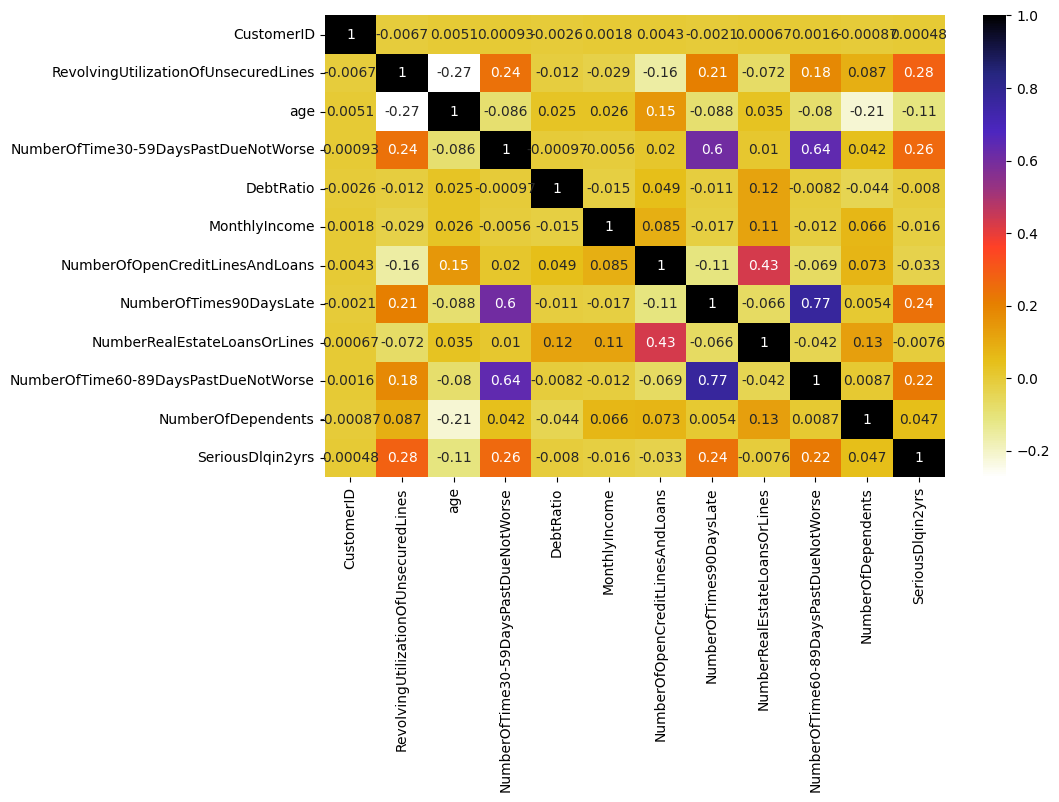

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(new_train.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

Comment: 
As evident from the correlation heatmap provided, we can deduce that the attributes most strongly correlated with "SeriousDlqin2yrs" are "NumberOfTime30-59DaysPastDueNotWorse," "NumberOfTime60-89DaysPastDueNotWorse," and "NumberOfTimes90DaysLate."

Furthermore, the "NumberofOpenCreditLinesandLoans" and "NumberofRealEstateLoansorLines" also exhibit noteworthy correlations with the target variable.

### Bivariate Analysis

In [49]:
def plot_boxplot_violinplot(column1, column2):
    """
    Plot a side-by-side comparison of boxplot and violin plot for two columns.
    
    Args:
        column1 (str): Name of the first column.
        column2 (str): Name of the second column.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.boxplot(x=column1, y=column2, data=new_train, palette='Set3', ax=ax1)
    ax1.set_title('Boxplot')
    
    sns.violinplot(x=column1, y=column2, data=new_train, palette='Set3', ax=ax2)
    ax2.set_title('Violin Plot')
    
    plt.tight_layout()
    plt.show()

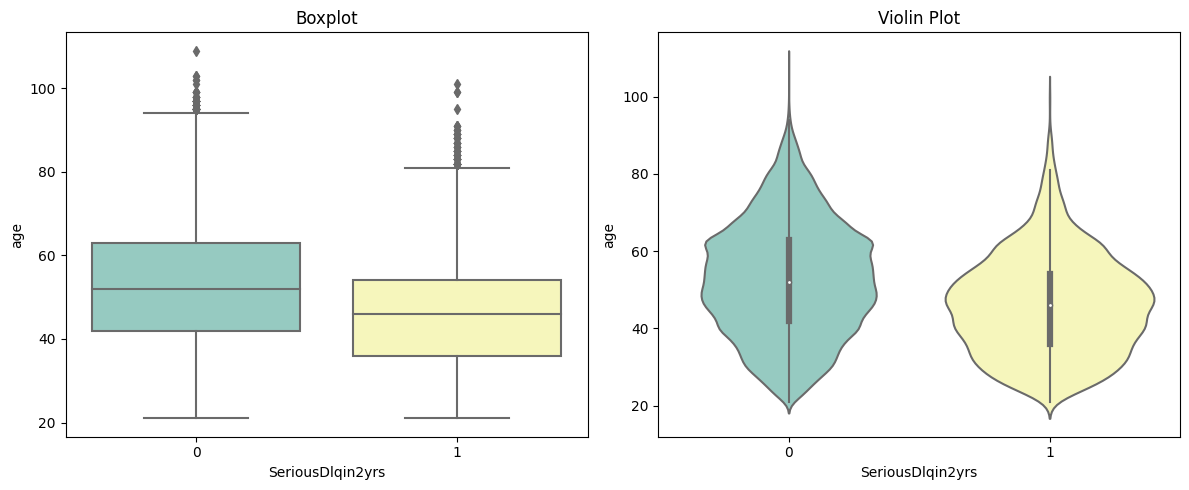

In [50]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'age')

Age has no significant on the target variable though most of the customers are in the mid 50 who has serious delinquency in 2 years.

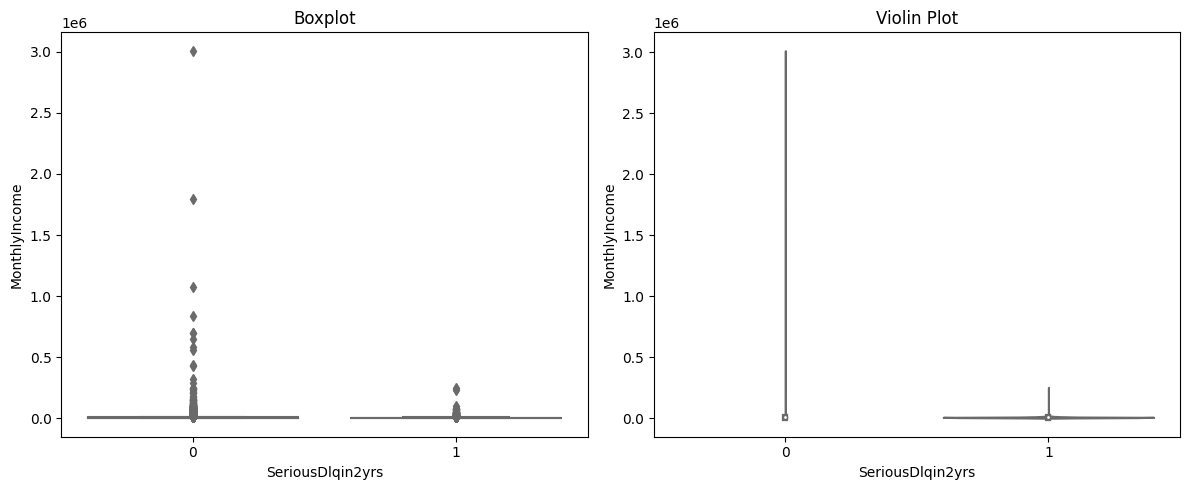

In [51]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'MonthlyIncome')

More or less similar relationship when target is 0 or 1

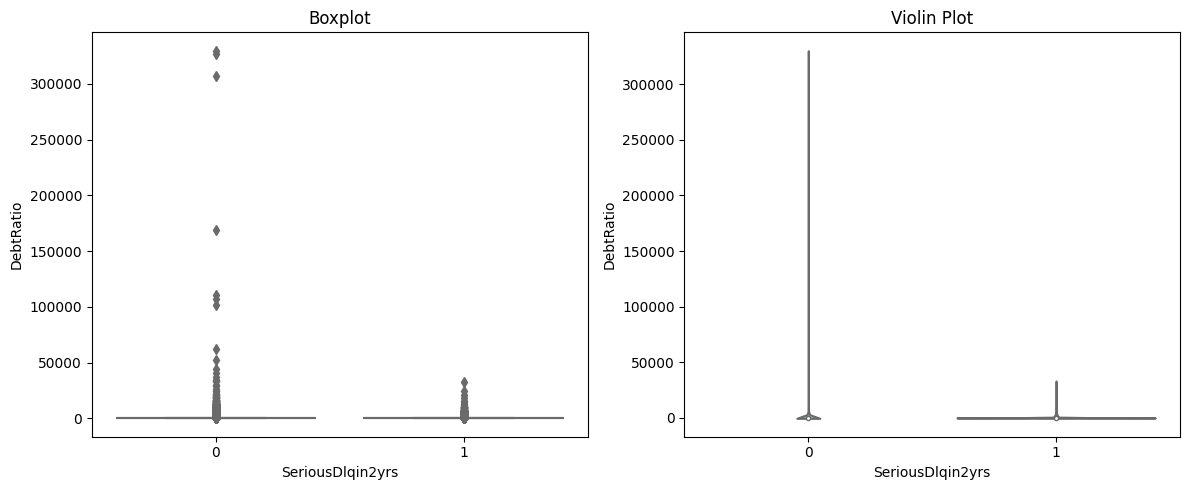

In [52]:
plot_boxplot_violinplot('SeriousDlqin2yrs','DebtRatio')

More or less similar relationship when target is 0 or 1.

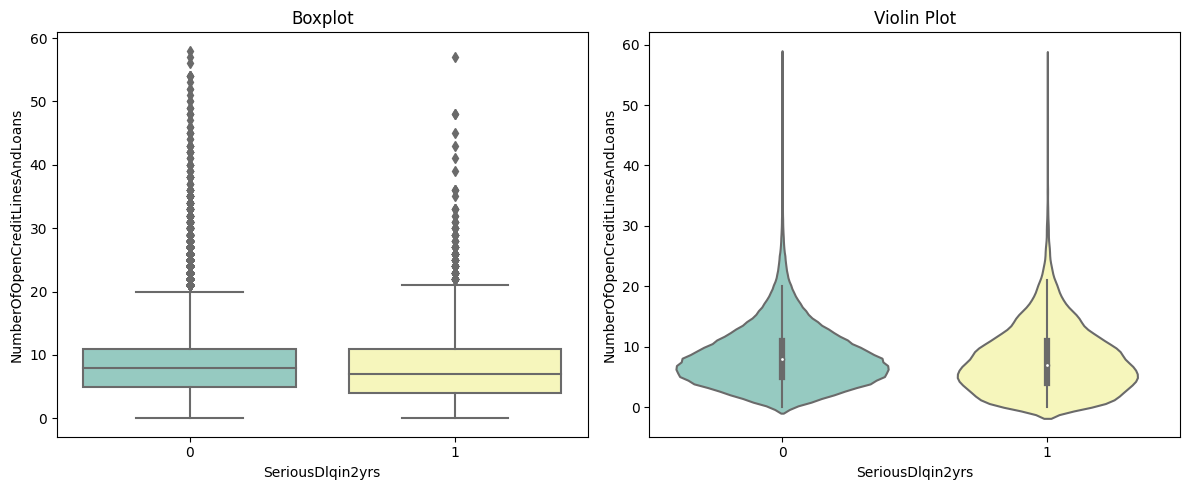

In [53]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfOpenCreditLinesAndLoans')

It is expected that the higher the utilization ratio, the higher the default rate is. Let me look into that by plotting the utilization ratio to the default rate.

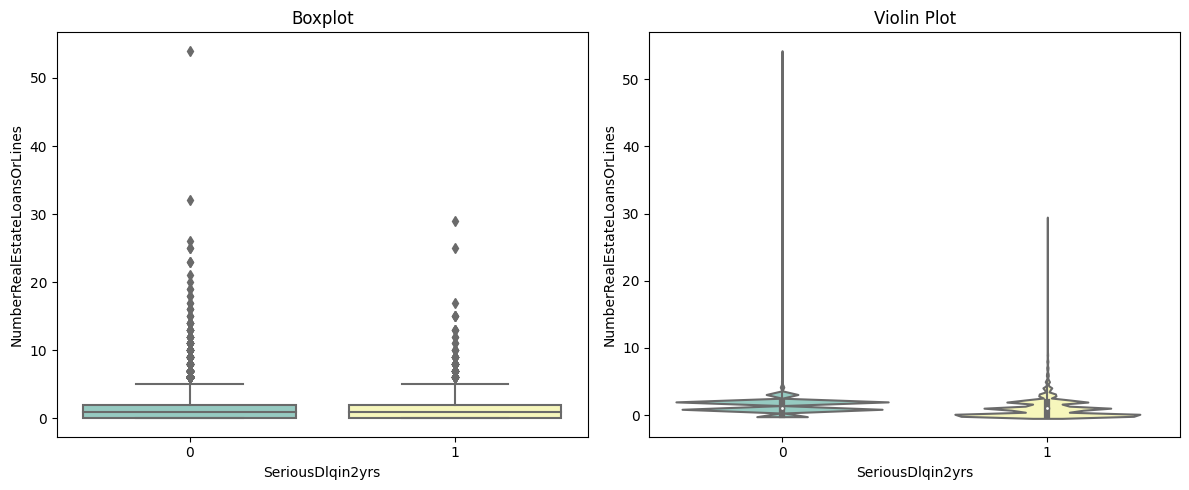

In [54]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberRealEstateLoansOrLines')

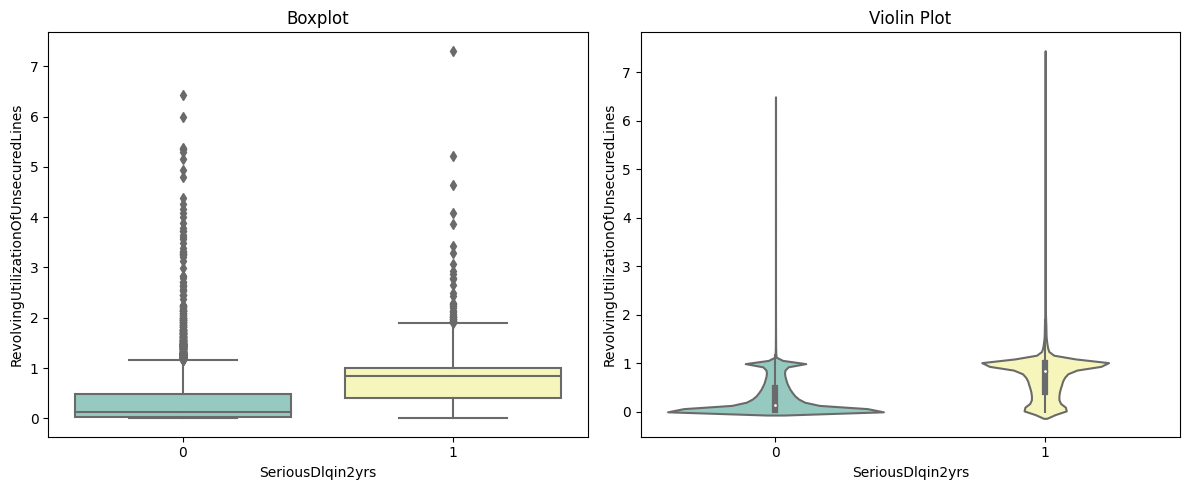

In [55]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines')

Feature description itself more the utlization of the credit resources or the ratio of amount owe to credit is more, serious delinquency is on a bit higher side.

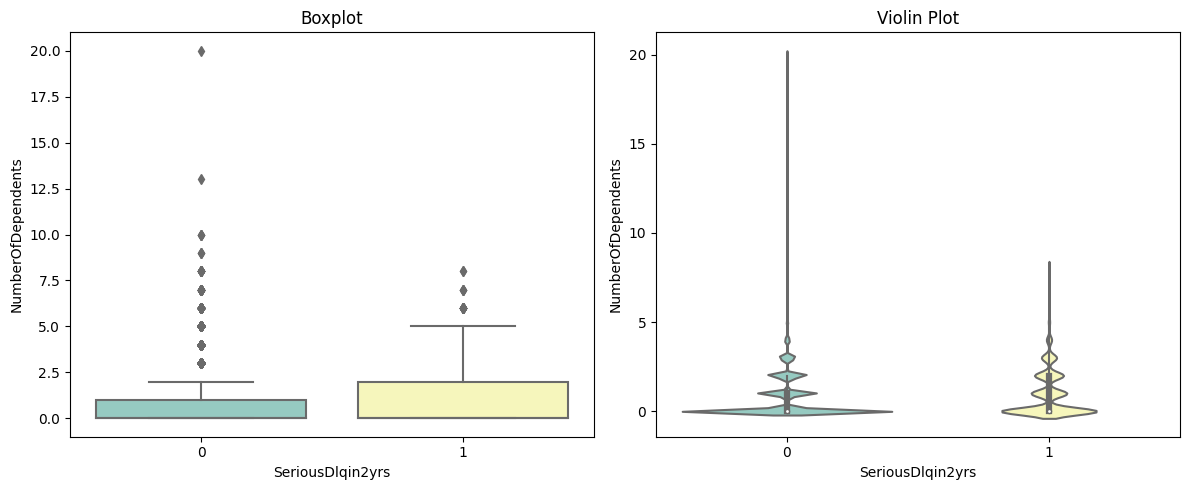

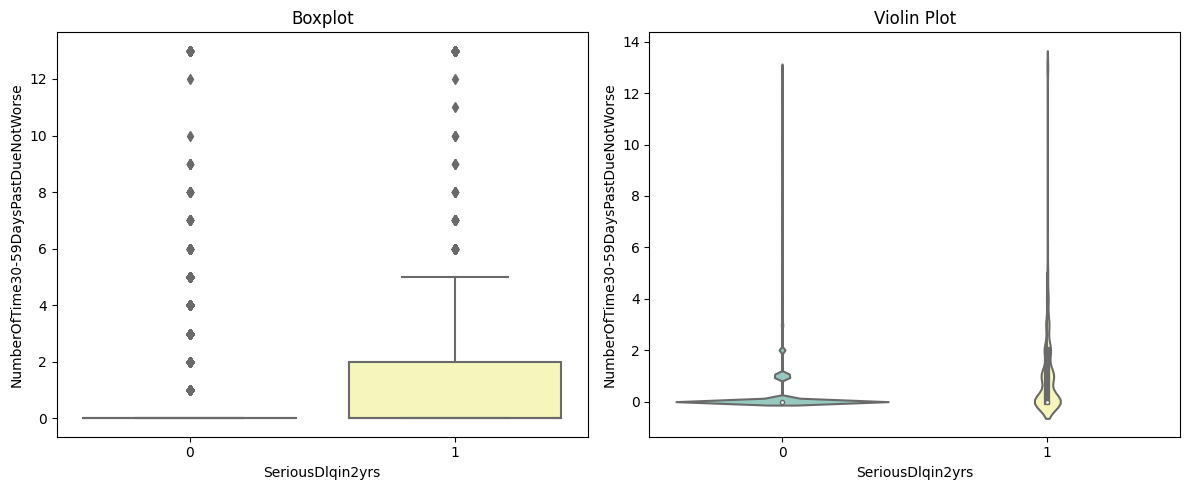

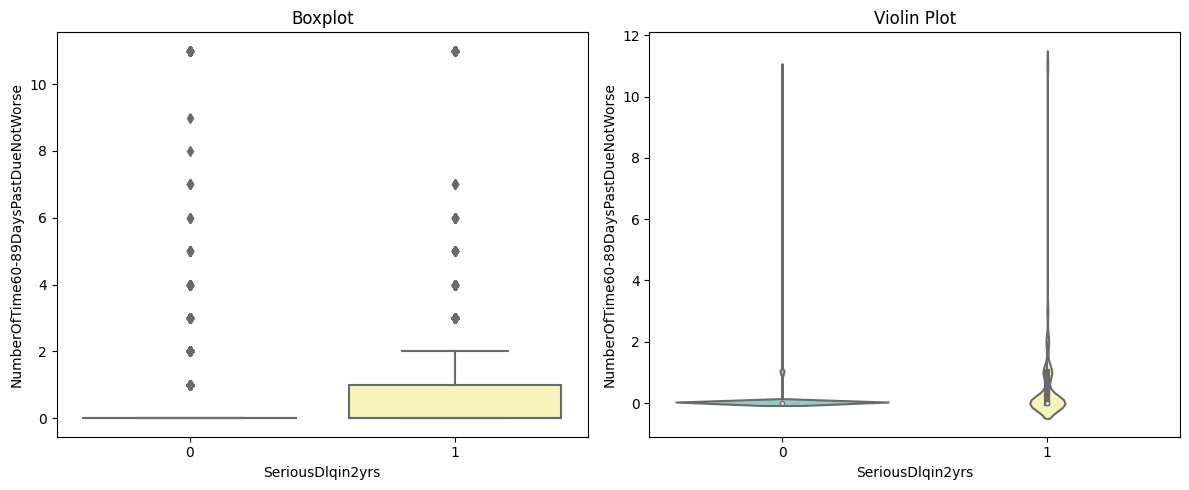

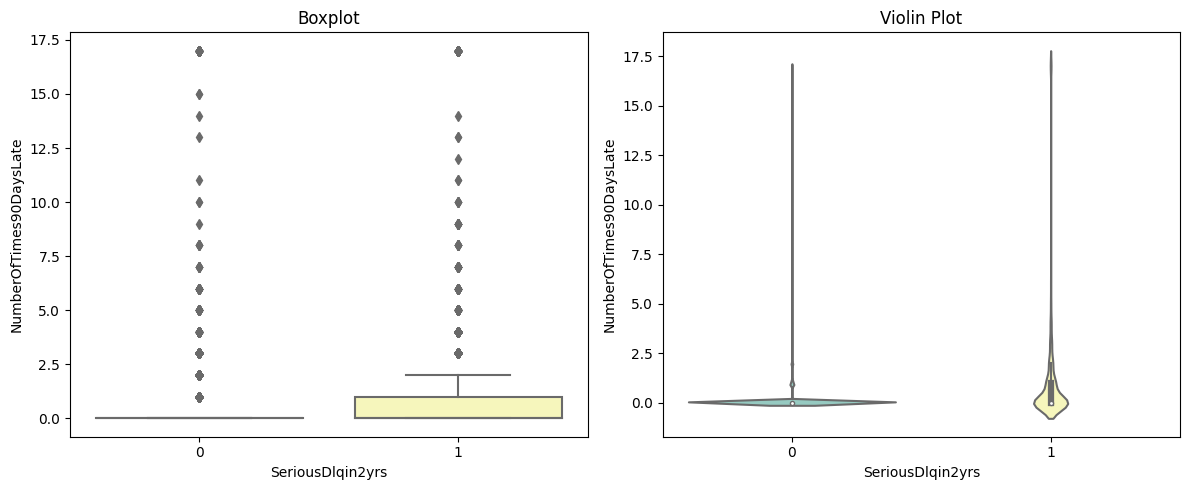

In [56]:
plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfDependents')

plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse')

plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTime60-89DaysPastDueNotWorse')

plot_boxplot_violinplot('SeriousDlqin2yrs', 'NumberOfTimes90DaysLate')

It is expected that the higher the utilization ratio, the higher the default rate is. Let me look into that by plotting the utilization ratio to default rate.

### Feature Engineering section

Making Combined Features

In [57]:
dataset = [new_train, new_test]
for data in dataset:
    data['CombinedPastDue']     = data['NumberOfTime30-59DaysPastDueNotWorse'] + data['NumberOfTime60-89DaysPastDueNotWorse'] + data['NumberOfTimes90DaysLate']
    data['CombinedCreditLoans'] = data['NumberOfOpenCreditLinesAndLoans'] + data['NumberRealEstateLoansOrLines']
    
new_train.columns

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans'],
      dtype='object')

Interaction of the Features

In [58]:
for data in dataset:
    data['MonthlyIncomePerPerson'] = data['MonthlyIncome']/(data['NumberOfDependents']+1)
    data['MonthlyDebt']            = data['MonthlyIncome']*data['DebtRatio']
    data['isRetired']              = np.where((data['age'] > 65), 1, 0)
    data['RevolvingLines']         = data['NumberOfOpenCreditLinesAndLoans']-data['NumberRealEstateLoansOrLines']
    data['hasRevolvingLines']      = np.where((data['RevolvingLines']>0),1,0)
    data['hasMultipleRealEstates'] = np.where((data['NumberRealEstateLoansOrLines']>=2),1,0)
    data['IsAlone']                = np.where((data['NumberOfDependents']==0),1,0)
    
new_train.columns

Index(['CustomerID', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs', 'CombinedPastDue',
       'CombinedCreditLoans', 'MonthlyIncomePerPerson', 'MonthlyDebt',
       'isRetired', 'RevolvingLines', 'hasRevolvingLines',
       'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

In [59]:
print("Shape of new_train:", new_train.shape)
print("Shape of new_test:", new_test.shape)

Shape of new_train: (119550, 21)
Shape of new_test: (29949, 21)


In [60]:
train_positive_proportion = new_train['SeriousDlqin2yrs'].sum() / len(new_train)
test_positive_proportion = new_test['SeriousDlqin2yrs'].sum() / len(new_test)

print(f"Proportion of positive class in new_train: {train_positive_proportion:.2%}")
print(f"Proportion of positive class in new_test: {test_positive_proportion:.2%}")

Proportion of positive class in new_train: 6.69%
Proportion of positive class in new_test: 6.69%


### Tackling Class Imbalance

Using:
    * Upsampling the Minority Class (default rate)
    * Downsampling the Majority Class (non-defaulters)
    * SMOTE - Synthethic Sampling

In [61]:
df_train = new_train.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_train = new_train['SeriousDlqin2yrs']

df_test = new_test.drop(columns=['CustomerID', 'SeriousDlqin2yrs'],axis=1)
y_test = new_test['SeriousDlqin2yrs']

Upsampling

In [62]:
# Select instances of the majority class (SeriousDlqin2yrs == 0)
df_majority = new_train[new_train['SeriousDlqin2yrs'] == 0]

# Select instances of the minority class (SeriousDlqin2yrs == 1)
df_minority = new_train[new_train['SeriousDlqin2yrs'] == 1]

# Upsample the minority class, generating 100,000 samples with replacement to align with the majority class size
df_minority_upsampled = resample(df_minority, replace=True, n_samples=100000, random_state=42)

# Concatenate the majority class and the upsampled minority class to create a balanced dataset
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display the value counts of the target variable in the upsampled dataset
print(df_upsampled['SeriousDlqin2yrs'].value_counts())

0    111548
1    100000
Name: SeriousDlqin2yrs, dtype: int64


In [63]:
y_train_upsampled = df_upsampled['SeriousDlqin2yrs']

# Drop unnecessary columns from the upsampled dataset
df_upsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], inplace=True)

# Display the shapes of the upsampled dataset, test dataset, and the corresponding target variables
print("Upsampled Train Data Shape:", df_upsampled.shape)
print("Test Data Shape:", df_test.shape)
print("Upsampled Train Target Shape:", y_train_upsampled.shape)
print("Test Target Shape:", y_test.shape)

Upsampled Train Data Shape: (211548, 19)
Test Data Shape: (29949, 19)
Upsampled Train Target Shape: (211548,)
Test Target Shape: (29949,)


Downsampling

In [64]:
# Display the value counts of the target variable in the original training dataset
print("Value Counts in 'SeriousDlqin2yrs' in Original Training Data:\n", new_train['SeriousDlqin2yrs'].value_counts())

Value Counts in 'SeriousDlqin2yrs' in Original Training Data:
 0    111548
1      8002
Name: SeriousDlqin2yrs, dtype: int64


In [65]:
# Downsampling: Keeping 8000 non-defaulters to balance with the defaulters
df_majority_downsampled = resample(df_majority, n_samples=8000, random_state=42)
df_downsampled = pd.concat([df_minority, df_majority_downsampled])

# Display the value counts of the target variable in the downsampled dataset
print("\nValue Counts in 'SeriousDlqin2yrs' in Downsampled Data:\n", df_downsampled['SeriousDlqin2yrs'].value_counts())


Value Counts in 'SeriousDlqin2yrs' in Downsampled Data:
 1    8002
0    8000
Name: SeriousDlqin2yrs, dtype: int64


In [66]:
# Extract the target variable for the downsampled dataset
y_train_downsampled = df_downsampled['SeriousDlqin2yrs']

# Drop unnecessary columns from the downsampled dataset
df_downsampled.drop(columns=['CustomerID', 'SeriousDlqin2yrs'], axis=1, inplace=True)

# Display the shapes of the downsampled dataset, test dataset, and the corresponding target variables
print("\nDownsampled Train Data Shape:", df_downsampled.shape)
print("Test Data Shape:", df_test.shape)
print("Downsampled Train Target Shape:", y_train_downsampled.shape)
print("Test Target Shape:", y_test.shape)


Downsampled Train Data Shape: (16002, 19)
Test Data Shape: (29949, 19)
Downsampled Train Target Shape: (16002,)
Test Target Shape: (29949,)


SMOTE

In [67]:
# Import SMOTE from imblearn library
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with specified parameters
smote = SMOTE(sampling_strategy='minority', k_neighbors=2, random_state=42)

# Apply SMOTE to balance the dataset
os_data_X, os_data_y = smote.fit_resample(df_train, y_train)

# Display the shape of the oversampled dataset and the proportion of positive class
print("Oversampled Train Data Shape:", os_data_X.shape)
print("Proportion of Positive Class in Oversampled Data:", sum(os_data_y) / len(os_data_y))

Oversampled Train Data Shape: (223096, 19)
Proportion of Positive Class in Oversampled Data: 0.5


Now the event rate in the training dataset is 50%.

In [68]:
# Making a copy of the dataframes so that transformed df and original df are separate to compare results

os_data_X_transformed = os_data_X.copy()
df_test_transformed = df_test.copy()

df_test_standardized = df_test.copy()

df_downsampled_transformed = df_downsampled.copy()
df_upsampled_transformed = df_upsampled.copy()

### Feature Transformation

Scaling of the features so that convergence of the model towards global minima can be acheived and training can be done faster. We willbe using a couple of feature transformation techniques: Box-Cox & Standardization.

We will check with how skewness changes after the transformation and we will be checking on SMOTE sampling technique datasets.

### Scaling features using Box-Cox Transformations

In [69]:
def SkewMeasure(df):
    # Select non-object (numerical) columns
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    
    # Calculate skewness for each column and sort in descending order
    skewM = df[nonObjectColList].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
    
    # Create a DataFrame to hold skewness values
    skew_df = pd.DataFrame({'skew': skewM})
    
    # Filter columns with absolute skewness greater than 0.5
    skewed_features = skew_df[abs(skew_df) > 0.5].dropna()
    
    return skewed_features


In [70]:
SkewMeasure(os_data_X_transformed)

skew
MonthlyIncome                         150.440778
MonthlyIncomePerPerson                111.019371
MonthlyDebt                           104.775409
DebtRatio                             103.291924
NumberOfTime60-89DaysPastDueNotWorse    8.765096
CombinedPastDue                         8.387815
NumberOfTimes90DaysLate                 8.266810
NumberOfTime30-59DaysPastDueNotWorse    5.584830
NumberRealEstateLoansOrLines            3.764830
isRetired                               2.556428
NumberOfDependents                      1.411704
hasMultipleRealEstates                  1.348802
RevolvingLines                          1.275257
CombinedCreditLoans                     1.115110
NumberOfOpenCreditLinesAndLoans         1.108339
RevolvingUtilizationOfUnsecuredLines    0.747770
hasRevolvingLines                      -4.126628

In [71]:
columnList = list(df_test_transformed.columns)

num_columns = len(columnList)
num_rows = (num_columns // 3) + (num_columns % 3 > 0)

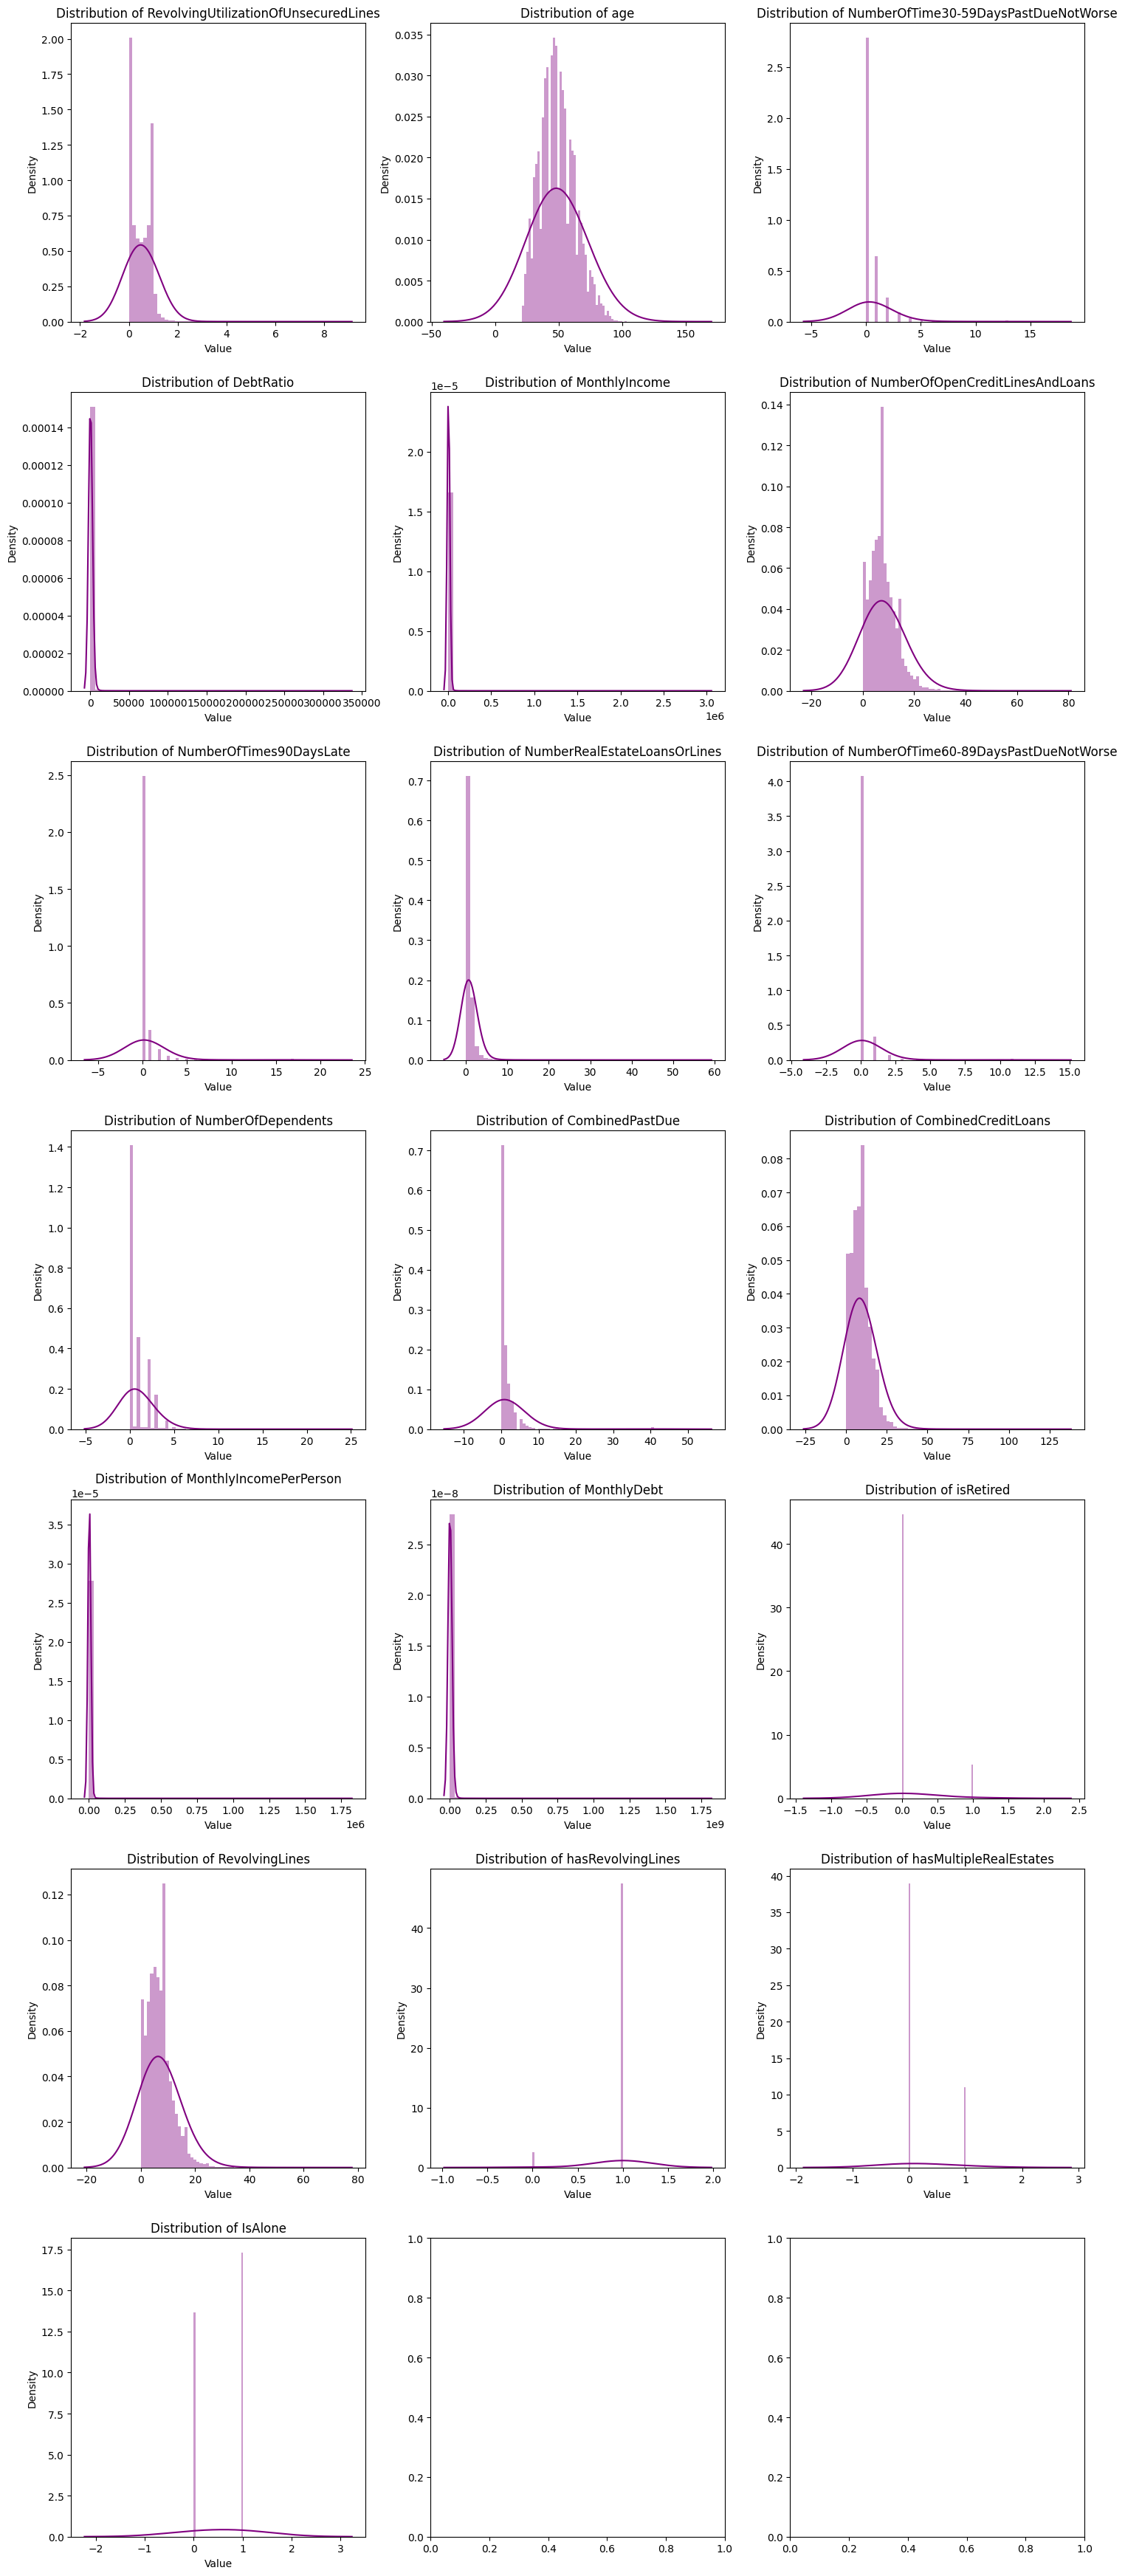

In [72]:
fig, axes = plt.subplots(num_rows, 3, figsize=[15, num_rows * 5])

for col, ax in zip(columnList, axes.ravel()):
    sns.distplot(os_data_X_transformed[col], ax=ax, kde_kws={'bw': 1.5}, color='purple')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    
plt.tight_layout()
plt.show()

In [73]:
df_train_transformed = df_train.copy()

skewM = SkewMeasure(df_train)

for i in skewM.index:
    df_train_transformed[i] = special.boxcox1p(df_train_transformed[i],0.15) #lambda = 0.15

### Standardization

In [74]:
scaler = StandardScaler().fit(os_data_X)

X_train_scaled = scaler.transform(os_data_X) 
X_test_scaled = scaler.transform(df_test)


In [75]:
scaler = StandardScaler().fit(df_upsampled_transformed)

X_train_scaled_upsampled = scaler.transform(df_upsampled_transformed) 
X_test_scaled_upsampled = scaler.transform(df_test_standardized)


In [76]:
scaler = StandardScaler().fit(df_downsampled_transformed)

X_train_scaled_downsampled = scaler.transform(df_downsampled_transformed) 
X_test_scaled_downsampled = scaler.transform(df_test_standardized)

### Modelling

Training the model:

- We will be training the model using different algorithms. 

- We will also be comparing the results using the transformed dataset and the original dataset. 

- We will check and compare which algorithm transformations work and which do not.

- We will be doing cross-validation and will see if the model performance is fluctuating using the statistical measures such as mean and standard deviation.

- Predicting the customers from the test dataset and comparing them with the true values from the test dataset using different evaluation metrics will give us which model to go for and which model is performing the best.

We will also be evaluating our model on different metrics and why some metrics might fail in our case study which is one of the most popular metrics to evaluate a model performance. Some common evaluation metrics I will be using across all modeling algorithms are:


Precision: How good a model is in predicting the events. True Positive/(True Positive + False Positives)

Recall: How good a model is able to capture relevant events. (coverage): True Positive/(True Positive + False Negatives)

F1 Score: Harmonic mean between Precision and Recall, this metric penalized either one of the lower scorer metrics so that trade-of can be maintained.

Area Under the Curve & ROC: How good a model is able to differentiate between the classes:
> It is plotted as a False Positive Rate on the x-axis and a True Positive Rate on the y-axis using different thresholds.
> The more the area or the line is above a straight diagonal line, the better is model performance as compared to randomly predicting the classes.

 We will be comparing the different modeling techniques' AUC results to see which ones are performing better as compared to others.

### Neural Network

In [77]:
# custom metrics
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [78]:
def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1,activation ='sigmoid'))
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=15)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data,test_label))
    
    return model

In [79]:
def compute_precisions_thresholds(data, labels, test_data, test_label, epochs, batch_size):
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_macro = [] ; P_micro = [];  R_macro = [] ;R_micro = []; F1_macro = [] ;F1_micro = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        prec_macro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='macro'),2)
        P_macro.append(prec_macro)
        prec_micro            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='micro'),2)
        P_micro.append(prec_micro)
        rec_macro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='macro'),2)
        R_macro.append(rec_macro)
        rec_micro             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='micro'),2)
        R_micro.append(rec_micro)
        f1_macro              = round(f1_score(test_label, y_test_pred_new, average='macro'),2)
        F1_macro.append(f1_macro)
        f1_micro              = round(f1_score(test_label, y_test_pred_new, average='micro'),2)
        F1_micro.append(f1_micro)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision Macro' : P_macro, 'Precision Micro' : P_micro,'Recall Macro' : R_macro, 'Recall Micro' : R_micro,'F1 Score Macro' : F1_macro, 'F1 Score Micro' : F1_micro})
    return metrics.sort_values(by=['Threshold'], ascending=False)

Appling Neural Network model on Box-Cox Transformed dataset

In [80]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [81]:
box_cox_metrics = compute_precisions_thresholds(os_data_X_transformed, os_data_y, df_test_transformed, y_test,epochs=15, batch_size=128)
box_cox_metrics

2023-08-23 23:19:30.008888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-23 23:19:30.008946: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-23 23:19:30.008980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-04809044-fc3c-4b8d-a24b-5d34b5d09764): /proc/driver/nvidia/version does not exist
2023-08-23 23:19:30.009690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/15
1743/1743 [==============================] - 7s 4ms/step - loss: 10345.01

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.47             0.93          0.50          0.93   
5       0.70             0.47             0.93          0.50          0.93   
4       0.60             0.57             0.93          0.50          0.93   
3       0.50             0.51             0.25          0.51          0.25   
2       0.40             0.53             0.07          0.50          0.07   
1       0.30             0.53             0.07          0.50          0.07   
0       0.25             0.53             0.07          0.50          0.07   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.48            0.93  
3            0.23            0.25  
2            0.07            0.07  
1            0.07            0.07  
0            0.07            0.07

Applying Neural Network on: Standardised Dataset

In [82]:
standardized_metrics = compute_precisions_thresholds(X_train_scaled, os_data_y, X_test_scaled, y_test,epochs=15, batch_size=128)
standardized_metrics

Epoch 1/15
1743/1743 [==============================] - 4s 2ms/step - loss: 0.4880 - precision: 0.7574 - recall: 0.8059 - val_loss: 0.4542 - val_precision: 0.1858 - val_recall: 0.7819
Epoch 2/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3989 - precision: 0.8052 - recall: 0.8353 - val_loss: 0.3574 - val_precision: 0.2252 - val_recall: 0.6726
Epoch 3/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3534 - precision: 0.8365 - recall: 0.8235 - val_loss: 0.3548 - val_precision: 0.2201 - val_recall: 0.6530
Epoch 4/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3428 - precision: 0.8435 - recall: 0.8208 - val_loss: 0.3281 - val_precision: 0.2508 - val_recall: 0.6600
Epoch 5/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.3368 - precision: 0.8464 - recall: 0.8249 - val_loss: 0.3278 - val_precision: 0.2437 - val_recall: 0.6333
Epoch 6/15
1743/1743 [==============================] - 3s 2ms/step - loss: 0.33

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.68             0.93          0.50          0.93   
8       0.95             0.73             0.93          0.50          0.93   
7       0.90             0.74             0.93          0.52          0.93   
6       0.80             0.71             0.93          0.57          0.93   
5       0.70             0.67             0.92          0.64          0.92   
4       0.60             0.63             0.89          0.72          0.89   
3       0.50             0.61             0.84          0.75          0.84   
2       0.40             0.59             0.78          0.77          0.78   
1       0.30             0.58             0.73          0.76          0.73   
0       0.25             0.57             0.70          0.76          0.70   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.49            0.93  
7            0.52            0.93  
6            0.59            0.93  
5            0.65            0.92  
4            0.66            0.89  
3            0.63            0.84  
2            0.59            0.78  
1            0.56            0.73  
0            0.54            0.70

Applying Neural Network on Original Standardized Dataset

In [83]:
scaler = StandardScaler().fit(df_train)

df_train_scaled = scaler.transform(df_train) 
df_test_scaled = scaler.transform(df_test)

base_metrics = compute_precisions_thresholds(df_train_scaled, y_train, df_test_scaled, y_test, epochs=10, batch_size=128)
base_metrics

Epoch 1/10
934/934 [==============================] - 3s 2ms/step - loss: 0.2353 - precision: 0.3686 - recall: 0.0921 - val_loss: 0.1840 - val_precision: 0.2689 - val_recall: 0.0373
Epoch 2/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1941 - precision: 0.3374 - recall: 0.0591 - val_loss: 0.1807 - val_precision: 0.3818 - val_recall: 0.0602
Epoch 3/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1904 - precision: 0.3850 - recall: 0.0739 - val_loss: 0.1800 - val_precision: 0.3935 - val_recall: 0.0622
Epoch 4/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1886 - precision: 0.4018 - recall: 0.0822 - val_loss: 0.1796 - val_precision: 0.3533 - val_recall: 0.0521
Epoch 5/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1876 - precision: 0.4482 - recall: 0.1008 - val_loss: 0.1791 - val_precision: 0.4917 - val_recall: 0.0955
Epoch 6/10
934/934 [==============================] - 2s 2ms/step - loss: 0.1860 - precisi

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93          0.50          0.93   
8       0.95             0.47             0.93          0.50          0.93   
7       0.90             0.47             0.93          0.50          0.93   
6       0.80             0.63             0.93          0.50          0.93   
5       0.70             0.81             0.93          0.50          0.93   
4       0.60             0.82             0.93          0.51          0.93   
3       0.50             0.79             0.94          0.54          0.94   
2       0.40             0.75             0.94          0.63          0.94   
1       0.30             0.71             0.93          0.69          0.93   
0       0.25             0.69             0.92          0.72          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.49            0.93  
4            0.50            0.93  
3            0.56            0.94  
2            0.67            0.94  
1            0.70            0.93  
0            0.70            0.92

Applying Neural Network on Upsampled Dataset

In [84]:
unsampled_metrics = compute_precisions_thresholds(X_train_scaled_upsampled, y_train_upsampled, df_test_standardized, y_test, epochs=10, batch_size=128)
unsampled_metrics

Epoch 1/10
1653/1653 [==============================] - 7s 4ms/step - loss: 0.5096 - precision: 0.7589 - recall: 0.7236 - val_loss: 5227.6626 - val_precision: 0.0539 - val_recall: 0.0420
Epoch 2/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4814 - precision: 0.7722 - recall: 0.7521 - val_loss: 5668.3398 - val_precision: 0.0478 - val_recall: 0.0932
Epoch 3/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4765 - precision: 0.7738 - recall: 0.7568 - val_loss: 6131.2998 - val_precision: 0.0719 - val_recall: 0.0154
Epoch 4/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4747 - precision: 0.7732 - recall: 0.7582 - val_loss: 3186.1829 - val_precision: 0.0310 - val_recall: 0.0051
Epoch 5/10
1653/1653 [==============================] - 3s 2ms/step - loss: 0.4732 - precision: 0.7746 - recall: 0.7589 - val_loss: 2505.5837 - val_precision: 0.0303 - val_recall: 0.0051
Epoch 6/10
1653/1653 [==============================] - 3s 2ms/st

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.49             0.93           0.5          0.93   
8       0.95             0.49             0.93           0.5          0.93   
7       0.90             0.49             0.93           0.5          0.93   
6       0.80             0.49             0.93           0.5          0.93   
5       0.70             0.49             0.93           0.5          0.93   
4       0.60             0.49             0.93           0.5          0.93   
3       0.50             0.49             0.93           0.5          0.93   
2       0.40             0.49             0.92           0.5          0.92   
1       0.30             0.49             0.92           0.5          0.92   
0       0.25             0.49             0.92           0.5          0.92   

   F1 Score Macro  F1 Score Micro  
9            0.49            0.93  
8            0.49            0.93  
7            0.49            0.93  
6            0.49            0.93  
5            0.49            0.93  
4            0.49            0.93  
3            0.49            0.93  
2            0.49            0.92  
1            0.49            0.92  
0            0.49            0.92

Applying Neural Network on Downsampled Dataset

In [85]:
downsampled_metrics = compute_precisions_thresholds(X_train_scaled_downsampled, y_train_downsampled, df_test_standardized, y_test, epochs=10, batch_size=128)
downsampled_metrics

Epoch 1/10
126/126 [==============================] - 4s 30ms/step - loss: 0.6202 - precision: 0.6704 - recall: 0.6357 - val_loss: 692.6796 - val_precision: 0.1076 - val_recall: 0.0828
Epoch 2/10
126/126 [==============================] - 0s 4ms/step - loss: 0.5373 - precision: 0.7636 - recall: 0.7226 - val_loss: 27251.4746 - val_precision: 0.0746 - val_recall: 0.7822
Epoch 3/10
126/126 [==============================] - 0s 3ms/step - loss: 0.5214 - precision: 0.7645 - recall: 0.7225 - val_loss: 1819.2759 - val_precision: 0.0734 - val_recall: 0.0185
Epoch 4/10
126/126 [==============================] - 0s 4ms/step - loss: 0.5156 - precision: 0.7766 - recall: 0.7395 - val_loss: 2635.6882 - val_precision: 0.0772 - val_recall: 0.4334
Epoch 5/10
126/126 [==============================] - 0s 4ms/step - loss: 0.5084 - precision: 0.7746 - recall: 0.7504 - val_loss: 641.9161 - val_precision: 0.1371 - val_recall: 0.0602
Epoch 6/10
126/126 [==============================] - 0s 4ms/step - loss: 0

Threshold  Precision Macro  Precision Micro  Recall Macro  Recall Micro  \
9       0.96             0.47             0.93           0.5          0.93   
8       0.95             0.47             0.93           0.5          0.93   
7       0.90             0.47             0.93           0.5          0.93   
6       0.80             0.47             0.93           0.5          0.93   
5       0.70             0.47             0.93           0.5          0.93   
4       0.60             0.47             0.93           0.5          0.93   
3       0.50             0.47             0.93           0.5          0.93   
2       0.40             0.63             0.93           0.5          0.93   
1       0.30             0.63             0.93           0.5          0.93   
0       0.25             0.59             0.93           0.5          0.93   

   F1 Score Macro  F1 Score Micro  
9            0.48            0.93  
8            0.48            0.93  
7            0.48            0.93  
6            0.48            0.93  
5            0.48            0.93  
4            0.48            0.93  
3            0.48            0.93  
2            0.48            0.93  
1            0.48            0.93  
0            0.48            0.93

- It can be clearly seen that Deep learning models require scaling of the features so that error can be minimised when features are nearly of the same scale so that backpropagation of errors can be there which results in better optimization

- No effect on Neural Network Models whether samples are downsampled or upsampled but that is not the case when synthetic sampling is used

- Results are more or less the same using Box-Cox transformations and Standardization

Training the Model and Predicting on Unseen Dataset:

Our approach involves employing four distinct modeling techniques:

- Logistic Regression

-  Random Forest

- XGBoost

- Light GBM

For each of these techniques, we will carry out training and prediction on an unseen dataset. Metrics that are relevant to each modeling technique will be computed, providing a comprehensive assessment of their performance.

In our evaluation, we will consider the Confusion Matrix figures, comprising the following values:

True Negatives (TN)
False Positives (FP)
False Negatives (FN)
True Positives (TP)

Furthermore, to gain an overview of the classifiers' performances, we will construct a joint plot depicting the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) metric. This graphical representation will allow us to visually compare how well each classifier distinguishes between classes.

### Different ML Models

In [86]:
def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_macro  = precision_score(y_test, y_pred, average='macro')*100
    prec_scr_micro  = precision_score(y_test, y_pred, average='micro')*100
    rec_scr_macro   = recall_score(y_test ,y_pred, average='macro')*100
    rec_scr_micro   = recall_score(y_test ,y_pred, average='micro')*100
    f1_scr_macro    = f1_score(y_test, y_pred, average='macro')*100 
    f1_scr_micro    = f1_score(y_test, y_pred, average='micro')*100 
    return prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm

In [87]:
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Macro', 'Precision Micro', 'Recall Macro','Recall Micro', 'F1 Score Macro', 'F1 Score Micro', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_macro, prec_scr_micro, rec_scr_macro, rec_scr_micro, f1_scr_macro, f1_scr_micro, cm])
    series_result = pd.Series(data=result, index=cols)
    
    return series_result

In [88]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42)
}

Evolution of Tree-Based Algorithms Leading to XGBoost:

The evolution of tree-based algorithms has led to the development of XGBoost, a highly optimized gradient boosting algorithm. Here is a breakdown of the progression:

- Decision Tree: A visual representation of potential solutions to a decision based on specific conditions.

- Bagging: Also known as Bootstrap Aggregating, bagging is a meta-algorithm that combines predictions from multiple decision trees using majority voting.

- Random Forest: This algorithm is built upon bagging principles. It constructs a collection of decision trees, where each tree uses only a random subset of features, enhancing diversity and robustness.

- Boosting: Boosting involves building models sequentially, focusing on minimizing errors from previous models while increasing the influence of high-performing models. 

- Gradient Boosting: This technique employs the gradient descent algorithm to sequentially create models that correct errors made by previous models. It's a form of iterative improvement.

- XGBoost: XGBoost stands for "Extreme Gradient Boosting," representing the pinnacle of this evolutionary journey. It takes gradient boosting to the next level by optimizing several aspects:

> Parallel Processing: XGBoost leverages parallel processing capabilities, making it faster and more efficient. Tree Pruning: It applies tree pruning techniques to prevent overfitting, which can lead to biased predictions. Handling Missing Values: XGBoost has mechanisms to effectively manage missing values in the dataset. Regularization: To prevent overfitting, XGBoost incorporates regularization techniques.

This progression has resulted in XGBoost becoming a powerful algorithm that produces accurate and generalized predictions while mitigating issues like bias and overfitting.

Training Box-Cox Transformed Dataset using ML Algorithms

In [89]:
frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], os_data_X_transformed, df_test_transformed, os_data_y, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

[LightGBM] [Info] Number of positive: 89238, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1897
[LightGBM] [Info] Number of data points in the train set: 178476, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 89239, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 178477, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> inits

Random Forest  \
Mean Accuracy                              0.934   
Accuracy deviation                         0.018   
Precision Macro                        63.338018   
Precision Micro                           89.412   
Recall Macro                           69.349069   
Recall Micro                              89.412   
F1 Score Macro                         65.545904   
F1 Score Micro                            89.412   
Confusion Matrix    [[25852, 2092], [1079, 926]]   

                                         XGBoost  \
Mean Accuracy                              0.882   
Accuracy deviation                         0.025   
Precision Macro                        60.287081   
Precision Micro                        85.268289   
Recall Macro                           71.573042   
Recall Micro                           85.268289   
F1 Score Macro                         62.674365   
F1 Score Micro                         85.268289   
Confusion Matrix    [[24419, 3525], [887, 1118]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.517                         0.855  
Accuracy deviation                         0.007                         0.017  
Precision Macro                        51.417897                     60.153705  
Precision Micro                        85.762463                     82.917627  
Recall Macro                           51.907117                     75.313426  
Recall Micro                           85.762463                     82.917627  
F1 Score Macro                         51.510895                     62.229249  
F1 Score Micro                         85.762463                     82.917627  
Confusion Matrix    [[25428, 2516], [1748, 257]]  [[23499, 4445], [671, 1334]]

Training Standardized dataset using ML algorithms

In [90]:
frame_std = {}
for key in clf_dict:

    classifier_result_std = metrics_calculation(clf_dict[key], X_train_scaled, X_test_scaled, os_data_y, y_test)
    frame_std[key]    = classifier_result_std
        
standardized_smote_df = pd.DataFrame(frame_std)
standardized_smote_df

[LightGBM] [Info] Number of positive: 89238, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1908
[LightGBM] [Info] Number of data points in the train set: 178476, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 89239, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1905
[LightGBM] [Info] Number of data points in the train set: 178477, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> inits

Random Forest  \
Mean Accuracy                              0.934   
Accuracy deviation                         0.019   
Precision Macro                        63.032653   
Precision Micro                        89.281779   
Recall Macro                           68.978357   
Recall Micro                           89.281779   
F1 Score Macro                         65.203946   
F1 Score Micro                         89.281779   
Confusion Matrix    [[25826, 2118], [1092, 913]]   

                                         XGBoost  \
Mean Accuracy                              0.881   
Accuracy deviation                         0.025   
Precision Macro                        60.326844   
Precision Micro                        85.391833   
Recall Macro                           71.454059   
Recall Micro                           85.391833   
F1 Score Macro                         62.727036   
F1 Score Micro                         85.391833   
Confusion Matrix    [[24464, 3480], [895, 1110]]   

                             Logistic Regression                     Light GBM  
Mean Accuracy                              0.827                         0.855  
Accuracy deviation                          0.02                         0.018  
Precision Macro                        60.216214                     60.046498  
Precision Micro                        84.527029                     82.850846  
Recall Macro                           72.749908                     75.046157  
Recall Micro                           84.527029                     82.850846  
F1 Score Macro                         62.547722                     62.081591  
F1 Score Micro                         84.527029                     82.850846  
Confusion Matrix    [[24129, 3815], [819, 1186]]  [[23489, 4455], [681, 1324]]

In [91]:
# Training Original dataset using hyperparameter which is balancing minority class as per the majority class

clf_dict_balanced = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight = {0:1, 1:10}),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight = 10),
    'Logistic Regression' : LogisticRegression(random_state=42, class_weight = {0:1, 1:10}),
    'Light GBM' : LGBMClassifier(random_state=42, scale_pos_weight = 10)
}

In [92]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[LightGBM] [Info] Number of positive: 6402, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 95640, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066939 -> initscore=-2.634697
[LightGBM] [Info] Start training from score -2.634697
[LightGBM] [Info] Number of positive: 6402, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 95640, number of used features: 19
[LightGBM] [In

Random Forest                       XGBoost  \
Mean Accuracy                             0.934                         0.865   
Accuracy deviation                        0.001                         0.002   
Precision Macro                       75.825877                     62.018829   
Precision Micro                       93.565728                     85.896023   
Recall Macro                          57.107222                     75.890947   
Recall Micro                          93.565728                     85.896023   
F1 Score Macro                        60.222459                     64.981585   
F1 Score Micro                        93.565728                     85.896023   
Confusion Matrix    [[27721, 223], [1704, 301]]  [[24435, 3509], [715, 1290]]   

                          Logistic Regression                     Light GBM  
Mean Accuracy                            0.93                         0.848  
Accuracy deviation                      0.003                         0.003  
Precision Macro                     49.264699                     61.861708  
Precision Micro                     92.791078                     84.740726  
Recall Macro                        49.932784                     77.980211  
Recall Micro                        92.791078                     84.740726  
F1 Score Macro                       48.54321                     64.703492  
F1 Score Micro                      92.791078                     84.740726  
Confusion Matrix    [[27781, 163], [1996, 9]]  [[23972, 3972], [598, 1407]]

- XGBoost & LightGBM performed better in terms of Recall. Random Forest works better in terms of Precision.

### Training original data using hyperparameter - balancing majority class 

In [93]:
frame_balanced_scaled= {}
for key in clf_dict_balanced:

    classifier_result_balanced_scaled = metrics_calculation(clf_dict_balanced[key], df_train_transformed, df_test_transformed, y_train, y_test)
    frame_balanced_scaled[key]    = classifier_result_balanced_scaled
        
balanced_df_scaled = pd.DataFrame(frame_balanced_scaled)        
balanced_df_scaled

[LightGBM] [Info] Number of positive: 6402, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 95640, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066939 -> initscore=-2.634697
[LightGBM] [Info] Start training from score -2.634697
[LightGBM] [Info] Number of positive: 6402, number of negative: 89238
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 95640, number of used features: 19
[LightGBM] [In

Random Forest                      XGBoost  \
Mean Accuracy                         0.934                        0.864   
Accuracy deviation                    0.001                        0.002   
Precision Macro                   53.796387                    56.327896   
Precision Micro                   93.288591                    91.929614   
Recall Macro                      50.014202                    52.202653   
Recall Micro                      93.288591                    91.929614   
F1 Score Macro                    48.313531                    52.643008   
F1 Score Micro                    93.288591                    91.929614   
Confusion Matrix    [[27938, 6], [2004, 1]]  [[27405, 539], [1878, 127]]   

                             Logistic Regression  \
Mean Accuracy                              0.856   
Accuracy deviation                         0.003   
Precision Macro                        49.532326   
Precision Micro                        76.409897   
Recall Macro                            48.83977   
Recall Micro                           76.409897   
F1 Score Macro                         47.628104   
F1 Score Micro                         76.409897   
Confusion Matrix    [[22543, 5401], [1664, 341]]   

                                        Light GBM  
Mean Accuracy                               0.848  
Accuracy deviation                          0.003  
Precision Macro                         56.334354  
Precision Micro                         63.581422  
Recall Macro                            74.604498  
Recall Micro                            63.581422  
F1 Score Macro                          50.163515  
F1 Score Micro                          63.581422  
Confusion Matrix    [[17291, 10653], [254, 1751]]

- Logistic Regression metrics are changed while all other model metrics remain the same. It requires - feature scaling.

Plotting ROC AUC for the ML models for the transformed dataset

In [94]:
models = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=42)
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(random_state=42)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42)
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(random_state=42)
    }
]

In [95]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

[LightGBM] [Info] Number of positive: 111548, number of negative: 111548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1900
[LightGBM] [Info] Number of data points in the train set: 223096, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


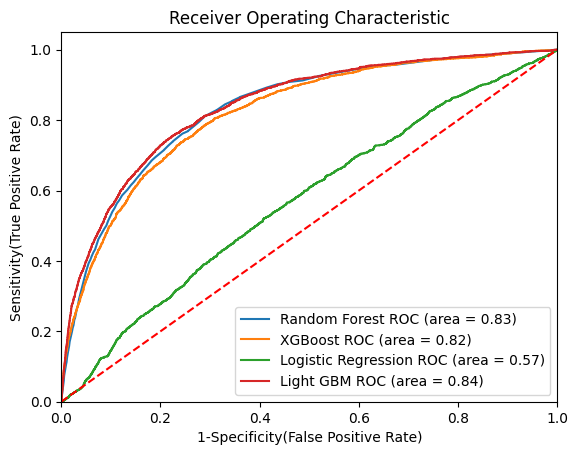

In [96]:
plot_multiplt_rocauc(models,os_data_X_transformed,os_data_y, df_test_transformed, y_test)

- AUC of all the models are on a similar scale except the XGBoost model which is 0.1 on a higher side. 

- AUC of XGBoost Light GBM are performing beyeer than the others

Takeaway: 

- Tree Based model doesn't require scaling of the features. 

- Statistical - Logistic Regression requires scaling of the features

- Upsampling of the Minority Class, Downsampling of the Majority Class and SMOTE sampling results are not better as compared to hyperparamater turning on using class weights in the model itself.

We will be proceeding with the original dataset without scaling of the featues but using class weights in the model itself.

Feature Importance
* We will be plotting top features by importance of all the ML algorithms.

* we will be plotting Logistic Regression features by correlation.

Model is  Random Forest
Model is  XGBoost
Model is  Light GBM


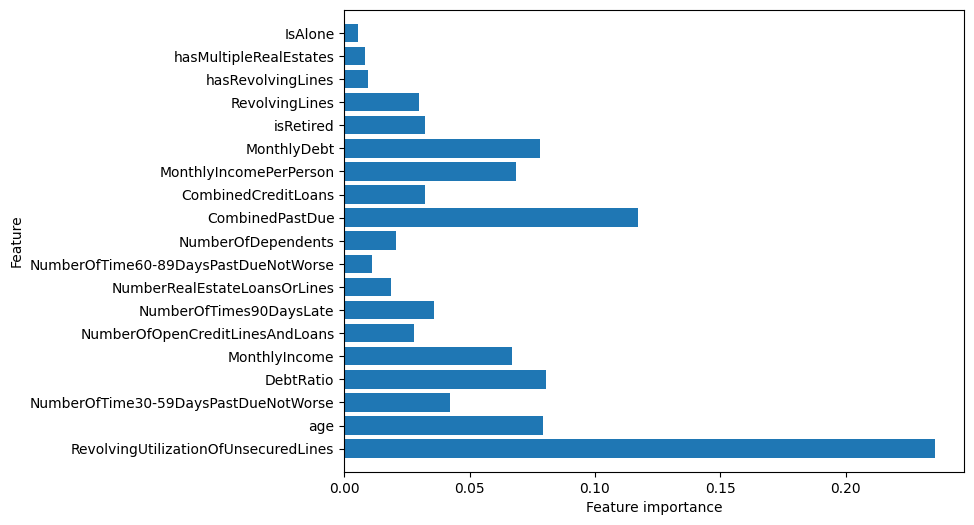

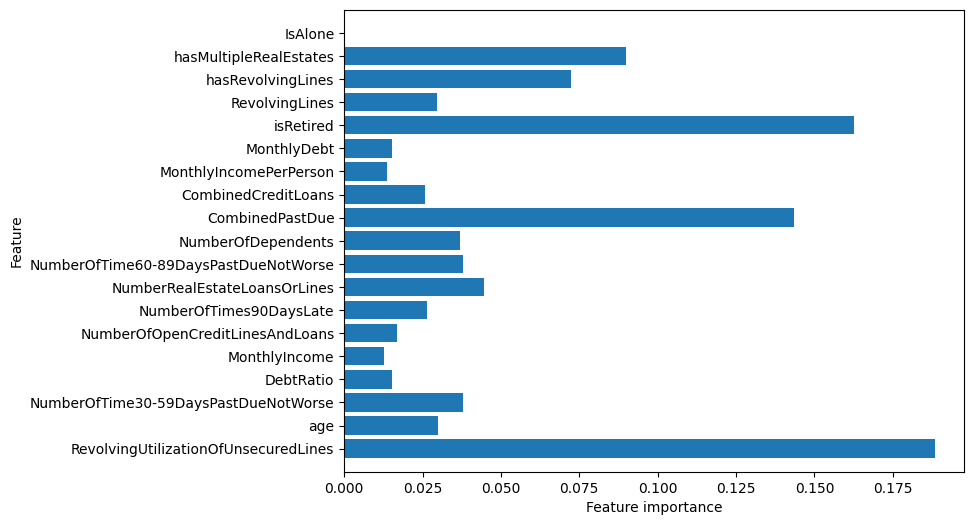

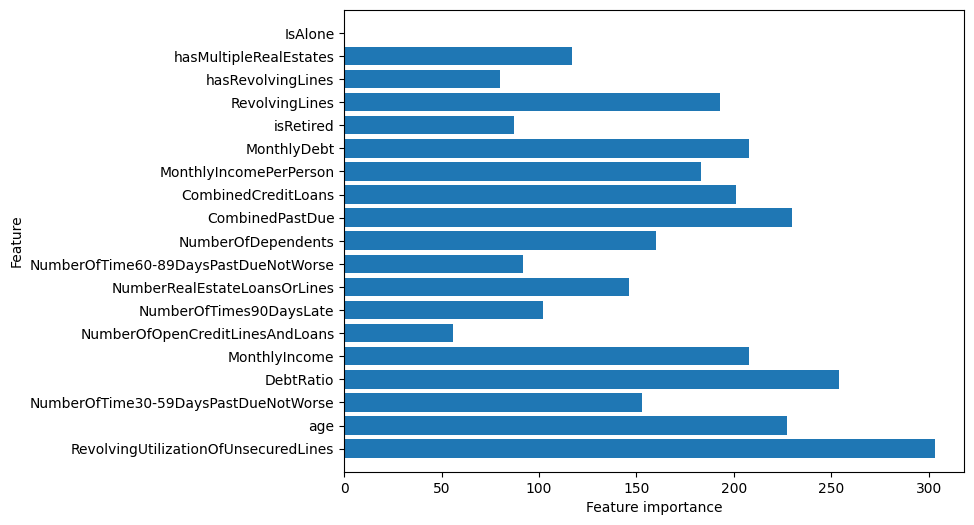

In [97]:
def plot_feature_importances(model, data):
    plt.figure(figsize=(8,6))
    n_features = data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
for key in clf_dict.keys():
  if key =='Logistic Regression':
    continue
  else:
    print('Model is ', key)
    plot_feature_importances(clf_dict[key], os_data_X_transformed)

> In all ML models, ratio of amount owed to the credit limit is the top feature followed by Combined Past Due which is the summation of all dues by a borrower.
> In Light GBM model, others features are also contributing to a greater extent

In [98]:
logreg = LogisticRegression(random_state=42)
logreg.fit(os_data_X_transformed, os_data_y)

coeff_df = pd.DataFrame(os_data_X_transformed.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

Feature   Correlation
4                          MonthlyIncome  1.100500e-05
3                              DebtRatio  6.703183e-07
10                       CombinedPastDue  4.164639e-07
2   NumberOfTime30-59DaysPastDueNotWorse  1.394799e-07
6                NumberOfTimes90DaysLate  1.296341e-07
0   RevolvingUtilizationOfUnsecuredLines  9.873746e-08
8   NumberOfTime60-89DaysPastDueNotWorse  6.455626e-08
9                     NumberOfDependents  5.410954e-08
16                     hasRevolvingLines  1.153380e-09
13                           MonthlyDebt -5.017109e-09
18                               IsAlone -1.146523e-08
17                hasMultipleRealEstates -1.867149e-08
7           NumberRealEstateLoansOrLines -2.866573e-08
14                             isRetired -3.827946e-08
11                   CombinedCreditLoans -6.410135e-08
5        NumberOfOpenCreditLinesAndLoans -7.979899e-08
15                        RevolvingLines -9.466561e-08
1                                    age -6.219405e-07
12                MonthlyIncomePerPerson -3.653743e-05

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability)

### Feature Selection using RFECV

We will be using RFECV on Random Forest to remove correlated features because they might be providing the same information.

In [99]:
def RFE(model, training_data, training_label):
    rfc = model
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(training_data, training_label)

    print('Optimal number of features: {}'.format(rfecv.n_features_))
    training_data_rfe = training_data.drop(training_data.columns[np.where(rfecv.support_ == False)[0]], axis=1)
    
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
    plt.show()
    
    dset = pd.DataFrame()
    dset['attr'] = training_data.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    dset = dset.sort_values(by='importance', ascending=False)


    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()
    
    return training_data_rfe.columns.tolist()

In [100]:
rfc = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
rfecv.fit(os_data_X_transformed, os_data_y)

print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 19


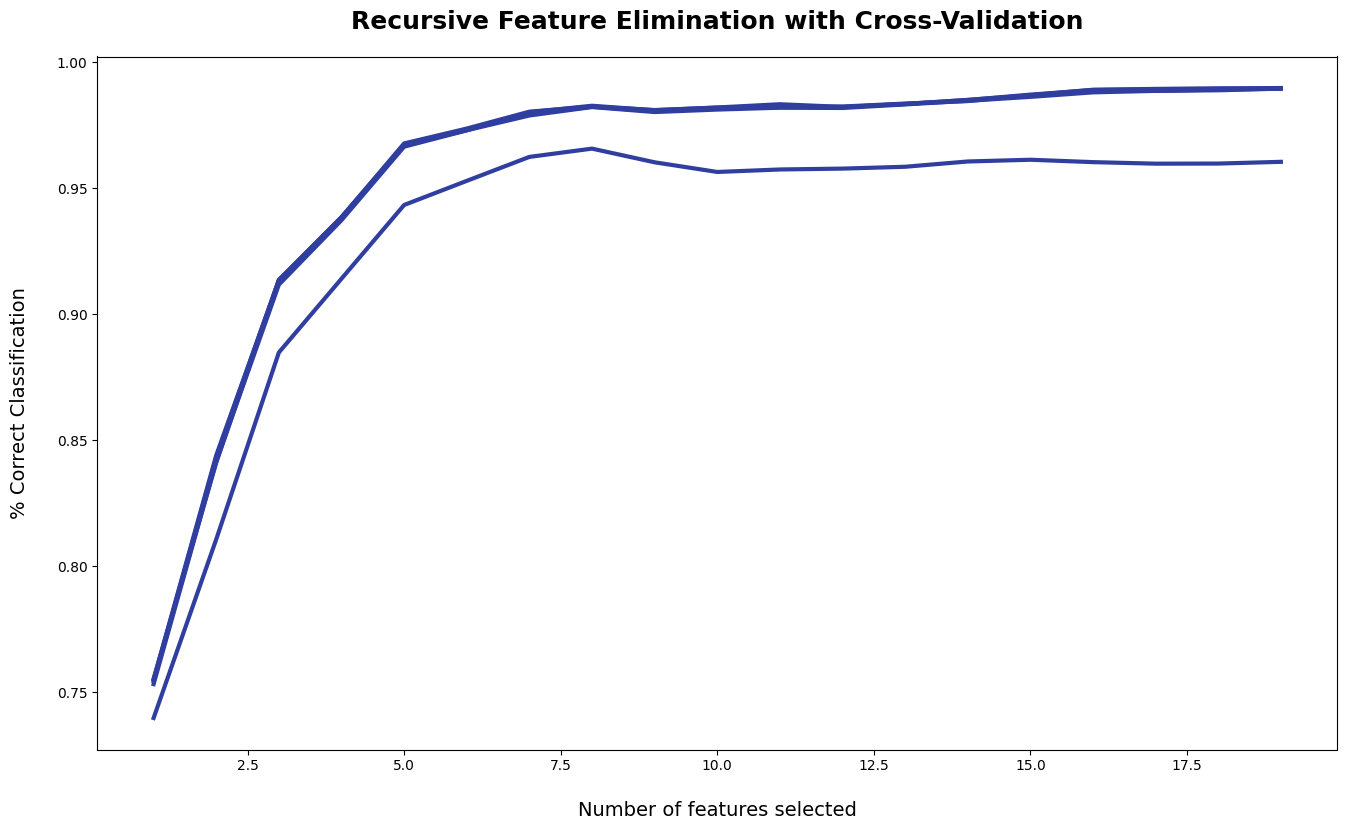

In [101]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [102]:
print(np.where(rfecv.support_ == False)[0])

os_data_X_transformed_rfe = os_data_X_transformed.drop(os_data_X_transformed.columns[np.where(rfecv.support_ == False)[0]], axis=1)
os_data_X_transformed_rfe.columns

[]


Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'CombinedPastDue', 'CombinedCreditLoans',
       'MonthlyIncomePerPerson', 'MonthlyDebt', 'isRetired', 'RevolvingLines',
       'hasRevolvingLines', 'hasMultipleRealEstates', 'IsAlone'],
      dtype='object')

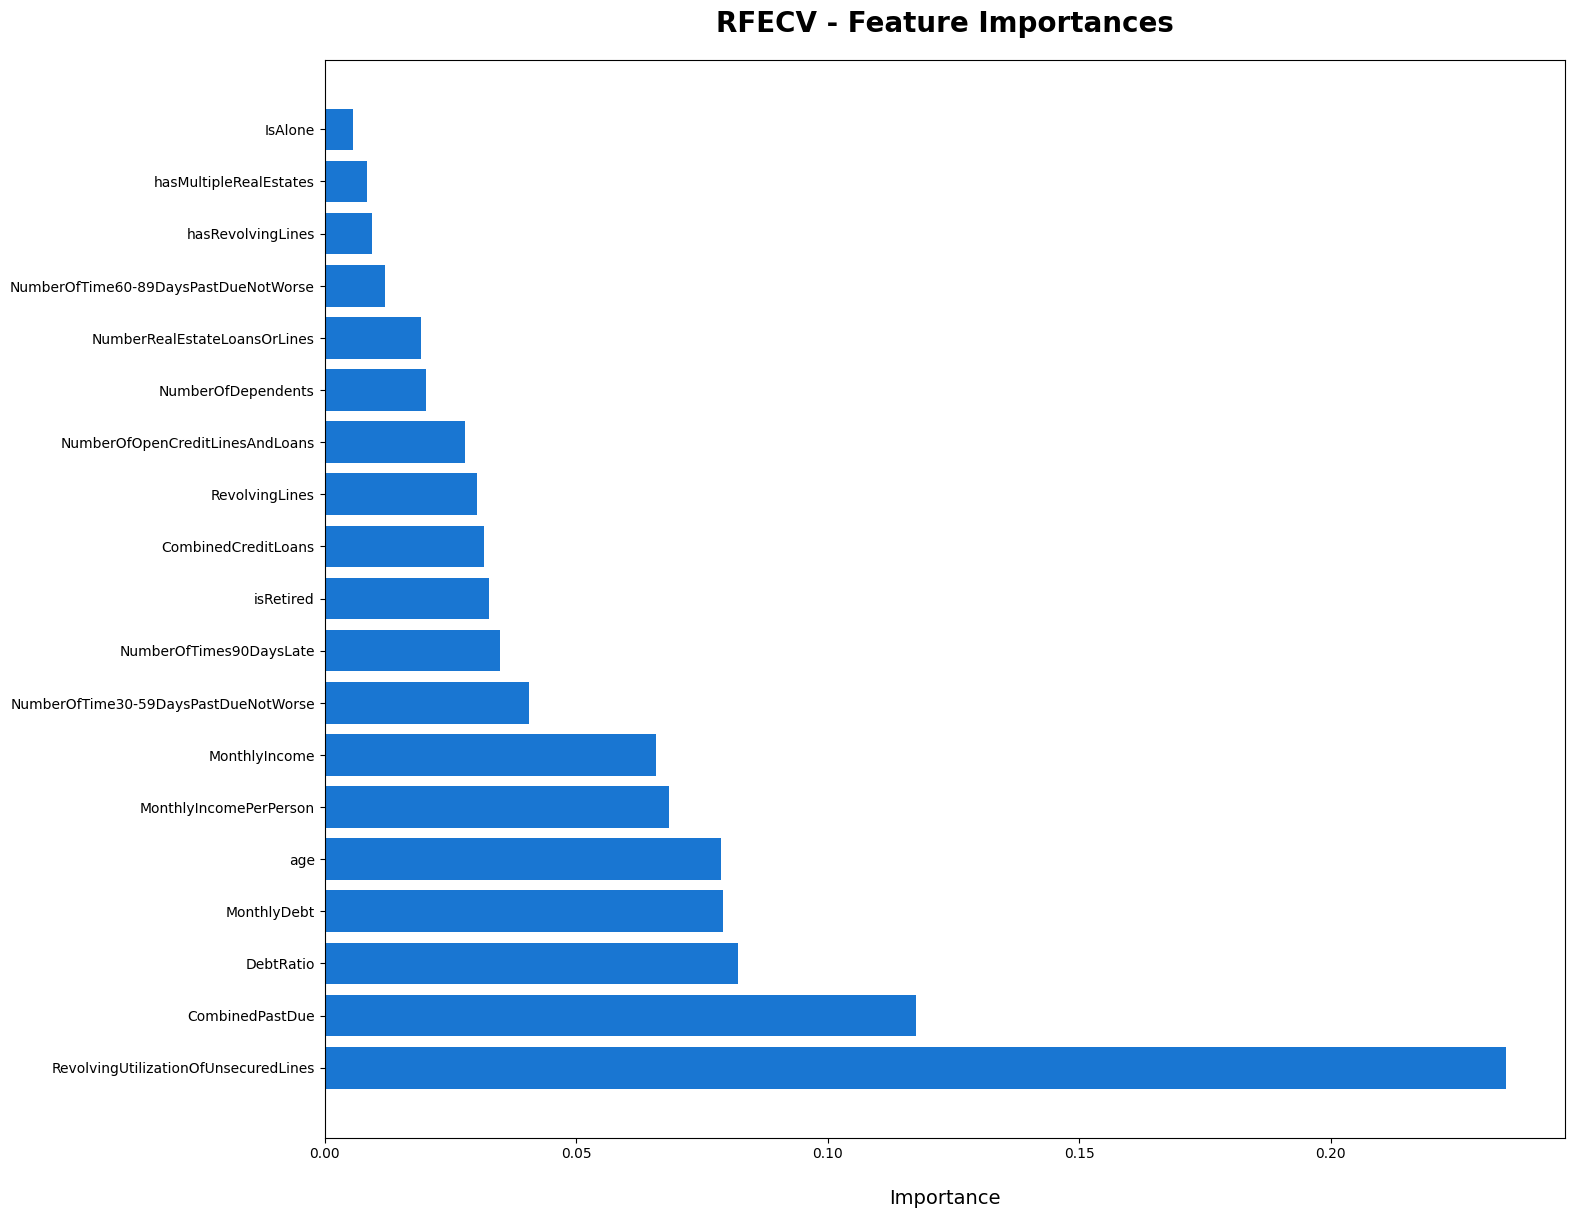

In [103]:
dset = pd.DataFrame()
dset['attr'] = os_data_X_transformed.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

Since our optimal performance is with the complete features and no feature is eliminated, we wil be proceeding with the complete Feature Engineered inputs.

Hypter Paramter Tuning for the Random Forest, XGBoost, and LightGBM

We will be using GridSearchCV for hyperparamater tuning

Now we will be using Metrics such as Precision, Recall, F1 Score on class 1 only
Previously * macro and * micro were used to give idea how these 2 separate metrics are calculated

In [104]:
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    
    result = []
    cols = ['Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
    
    model_name = {}
    class_str = str(classifier)
    if 'Random' in class_str:
        param_grid={
    "n_estimators":[27,36,100,200],
    "max_depth":[5,7,9,15],
    "min_samples_leaf":[2,4,6,8]
        }
        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(5))
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    elif 'XG' in class_str:
        model_name = {}
        parameters = {
    'n_estimators': [100, 200], 
  'max_depth': [3, 5, 8], 
  'gamma' : [0.25,0.5,1],
  'reg_alpha': [0.1, 0.25, 0.5],
  'reg_lambda': [0.5,1,1.15],
  'scale_pos_weight' : [8,10,12,15]
    }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    else:
        model_name = {}
        param_grid = {'n_estimators': [100,250,400],
          'min_split_gain' : [0.25,0.45,0.7],
         'max_depth': [4,7,10],
         'subsample': [0.65,0.85],
         'colsample_bytree': [0.45,0.65,0.85],
         'reg_lambda': [0.5,1,3,5],
         'num_leaves' : [30,50,70],
         'min_data_in_leaf' : [100,400,600]
         }
        
        model = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                          cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    prec_scr, rec_scr, f1_scr, cm = cal_score(test_label, y_pred)
    result.extend([prec_scr, rec_scr, f1_scr, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name

In [105]:
frame_hyperparamater = {} ; model_params = []
for key in clf_dict:
  print(key)
  if key == 'Logistic Regression':
    continue
    hyperparamater_result, model_paramters = hyperparameter_tuning(clf_dict[key], df_train, df_test, y_train, y_test)
    frame_hyperparamater[key]    = hyperparamater_result
    model_params.append(model_paramters)
        
tuned_df = pd.DataFrame(frame_hyperparamater)

Random Forest
XGBoost
Logistic Regression
Light GBM


In [106]:
model_params

[]

In [107]:
clf_dict_balanced = {'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10}),
           'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10),
            'Logistic Regression': LogisticRegression(random_state=42, class_weight={0:1,1:10}),
            'Light GBM': LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)}

In [108]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], df_train, df_test, y_train, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Info] Number of positive: 6402, number of negative: 89238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 95640, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066939 -> initscore=-2.634697
[LightGBM] [Info] Start training from score -2.634697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

Random Forest  \
Mean Accuracy                              0.899   
Accuracy deviation                         0.001   
Precision Macro                         65.45358   
Precision Micro                        89.685799   
Recall Macro                           74.935656   
Recall Micro                           89.685799   
F1 Score Macro                         68.621672   
F1 Score Micro                         89.685799   
Confusion Matrix    [[25699, 2245], [844, 1161]]   

                                         XGBoost        Logistic Regression  \
Mean Accuracy                              0.902                       0.93   
Accuracy deviation                         0.001                      0.003   
Precision Macro                        64.028085                  49.264699   
Precision Micro                        89.669104                  92.791078   
Recall Macro                           70.320185                  49.932784   
Recall Micro                           89.669104                  92.791078   
F1 Score Macro                         66.352107                   48.54321   
F1 Score Micro                         89.669104                  92.791078   
Confusion Matrix    [[25893, 2051], [1043, 962]]  [[27781, 163], [1996, 9]]   

                                       Light GBM  
Mean Accuracy                              0.845  
Accuracy deviation                         0.003  
Precision Macro                        61.734995  
Precision Micro                        84.436876  
Recall Macro                            78.16461  
Recall Micro                           84.436876  
F1 Score Macro                         64.499255  
F1 Score Micro                         84.436876  
Confusion Matrix    [[23866, 4078], [583, 1422]]

Plotting ROC AUC for the ML models for the original dataset

In [109]:
models_balanced = [
    {
    'label': 'Random Forest',
    'model': RandomForestClassifier(max_depth=15, min_samples_leaf=8, n_estimators=200, random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'XGBoost',
    'model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=200, random_state=42, reg_alpha=0.5, reg_lambda=1.15, scale_pos_weight=10)
    },
    {
    'label' : 'Logistic Regression',
    'model' : LogisticRegression(random_state=42, class_weight={0:1,1:10})
    },
    {
    'label' : 'Light GBM',
    'model' : LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)
    }
]

[LightGBM] [Info] Number of positive: 8002, number of negative: 111548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 119550, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066934 -> initscore=-2.634763
[LightGBM] [Info] Start training from score -2.634763


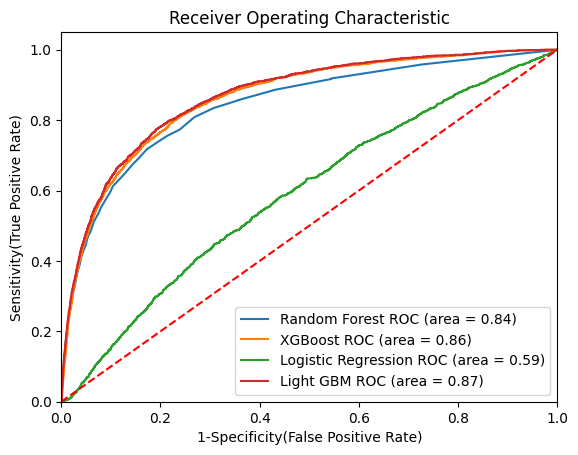

In [110]:
plot_multiplt_rocauc(models,df_train,y_train, df_test, y_test)

We will be going with the Light GBM model as it is performing better than the other models

In [111]:
model_lgb = LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400, min_split_gain=0.25, num_leaves=70, random_state=42, reg_lambda=5, subsample=0.65, scale_pos_weight=10)

model_lgb.fit(df_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Info] Number of positive: 8002, number of negative: 111548
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 119550, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066934 -> initscore=-2.634763
[LightGBM] [Info] Start training from score -2.634763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

LGBMClassifier(colsample_bytree=0.65, max_depth=4, min_data_in_leaf=400,
               min_split_gain=0.25, num_leaves=70, random_state=42,
               reg_lambda=5, scale_pos_weight=10, subsample=0.65)

In [112]:
y_pred = model_lgb.predict(df_test)
df_test['predictions'] = y_pred

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


In [113]:

predict_model_lgb = lambda x: model_lgb.predict_proba(x).astype(float)

Feature Importance and Model Explanation using SHAP and LIME

Why Interpretability is Important in Machine Learning Models:

1. Fairness: It's crucial to understand how features relate to the target variable's trends.

2. Pattern Discovery and Model Debugging: Uncovering the patterns captured by the model's features is essential for identifying and addressing issues.

3. Compliance with Regulations: Sometimes, regulatory bodies require explanations for model predictions.

4. Enhancing Black Box Transparency: Utilizing methods like SHAP can make complex models more transparent and understandable.

5. SHAP for Global Transparency: SHAP helps us grasp the overall model behavior, illustrating the impact of each feature on predictions.

6. LIME for Local Insights: LIME provides detailed insights into individual predictions by focusing on local intricacies.

7. SHAP Values for Feature Contribution: SHAP values quantify how much each feature contributes positively or negatively to predictions.

In essence, interpreting machine learning models empowers us to rectify issues, adhere to rules, and demystify complex models. SHAP and LIME tools enable us to comprehend both the comprehensive model landscape and specific prediction details.

#### SHAP(SHapely Additive exPlainations)

Variable Importance Plot — Global Interpretability

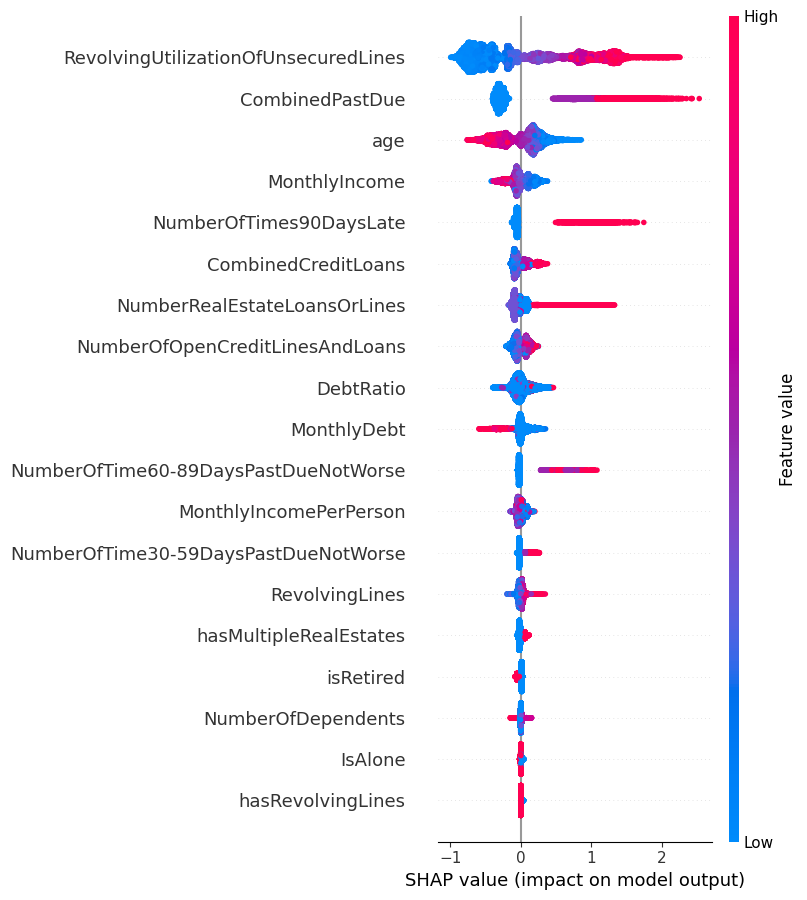

In [114]:
# drop the predictions column here
df_test = df_test.drop(columns = ['predictions'])
X_importance = df_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values[1], X_importance)

Variable Ranking: The variables are arranged from highest to lowest importance.

2. Impact Illustration: The horizontal position indicates whether a value's influence leads to a higher or lower prediction.

3. Original Value Indication: Colors indicate if the variable value is high (shown in red) or low (displayed in blue) for a specific observation.

4. Correlation Insight: A strong positive correlation exists between the "RevolvingUtilizationOfUnsecuredLines" and "Debt Ratio" variables. Both are associated with a higher prediction for defaulting. This correlation is reflected by the red color and positive impact on the X-axis.

5. Age Correlation Example: The "age" variable shows equal correlation with both the target and non-target variables. This lack of distinction may not contribute significantly to predictive performance.

6. Monthly Income Influence: The impact of "Monthly Income" on predictions is relatively weak, as indicated by its lower position and lesser effect.

SHAP Dependence Plot — Global Interpretability

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic or more complex.
The function automatically includes another variable that your chosen variable interacts most with.

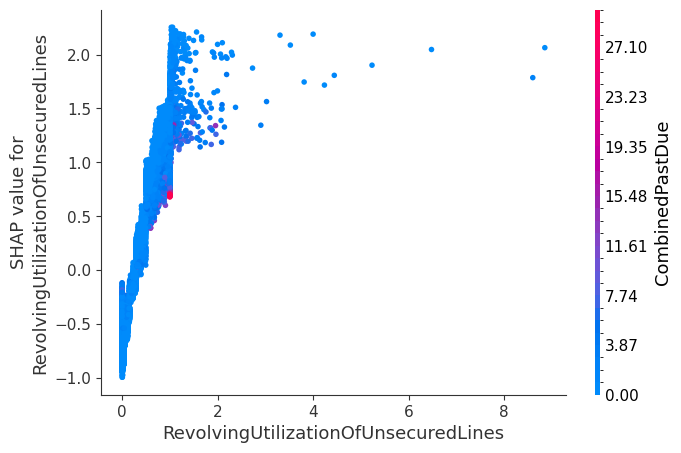

In [115]:
shap.dependence_plot("RevolvingUtilizationOfUnsecuredLines", shap_values[1], X_importance)

The following plot shows there is an very little linear and a bit of positive trend between “RevolvingUtilizationOfUnsecuredLines” and the target variable, and “RevolvingUtilizationOfUnsecuredLines” does not interact with “CombinedPastDue”.

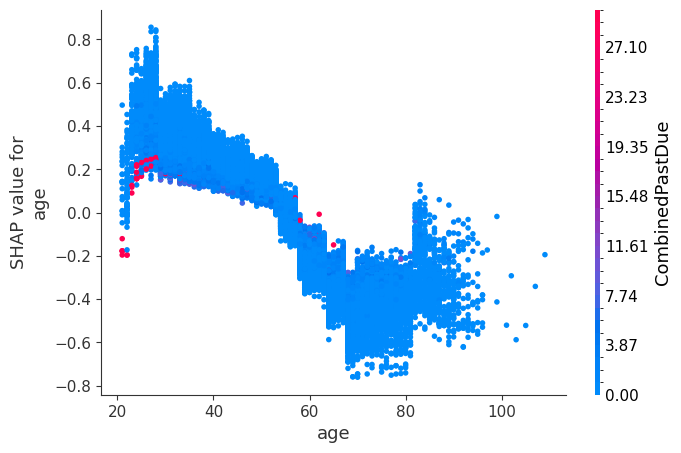

In [116]:
shap.dependence_plot("age", shap_values[1], X_importance)

The following plot shows there is an good linear and a negative trend between “age” and the target variable, and “age” interacts with “CombinedPastDue” not so much.

LIME(Local Interpretable Model Agnostic Explanations)

Understanding Individual Predictions with LIME:

LIME Technique: When we aim to comprehend how a specific prediction was generated for a particular observation, we turn to the LIME technique. LIME stands for "Local Interpretable Model-Agnostic Explanations."

Generating Explanations: LIME helps us create explanations for individual predictions. It's like zooming in on a single prediction to see how and why the model arrived at that particular outcome.

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


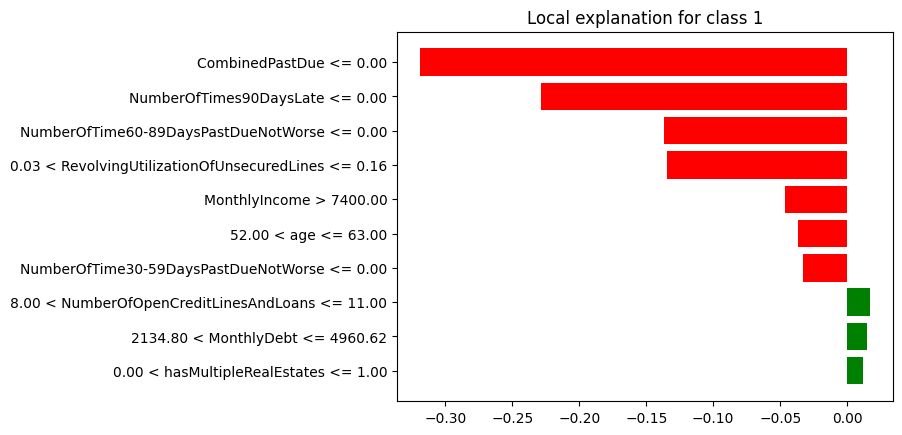

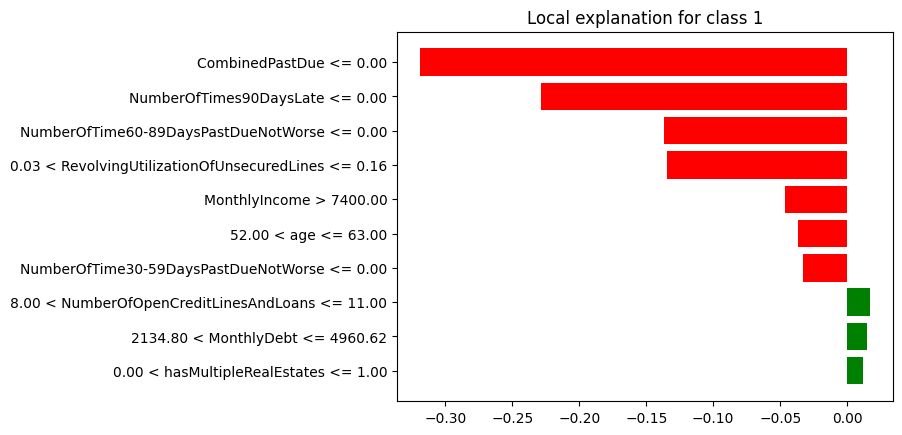

In [117]:
# creating the explainer function
explainer = LimeTabularExplainer(df_test.values, mode="classification", feature_names=df_test.columns)

exp = explainer.explain_instance(df_test.iloc[3], 
     predict_model_lgb, num_features=10)
exp.as_pyplot_figure()

Green/Red color: features that have positive correlations with the target are shown in green, otherwise red.
No of times 30-59, 59-90 days and 90 days past due having no values means not missed any due date showing veryr high negative correlation with the target
age having less values lower than 41 relatively show positive corrrelation with the target

### Storing new observations

In [118]:
# storing a new observation
i = 37
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


0.44685087409935476


Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on defaulting for this row.

In [119]:
# storing a new observation
i = 25
X_observation = df_test.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_lgb)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


0.3962638022667716


Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. For example, CombinedPastDue has a positive impact on non delinquency for this row which has value 0 and Monthly Income feature having value greater than 73000 contributing towards non delinquency.

### Future Work

Deployment (?)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=04809044-fc3c-4b8d-a24b-5d34b5d09764' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>